# Segmentez des clients d'un site e-commerce

# Notebook EDA
Olist, le Amazon brésilien, souhaite que je fournisse à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Je dois fournir à l’équipe marketing une description actionable de ma segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


In [1]:
# Importe toutes les librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# Importe tous les datas frames

df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

# Affiche toutes les colonnes

pd.set_option('display.max_columns', None) 

# 1. ANALYSE EXPLORATOIRE

In [2]:
# contient des informations sur le client et son emplacement

df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [3]:
df_customers.duplicated().sum() #nombre de doublon

0

In [4]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# informations sur les codes postaux brésiliens et ses coordonnées lat/lng

df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [6]:
df_geolocation.duplicated().sum() #nombre de doublon

261831

In [7]:
df_geolocation = df_geolocation.drop_duplicates() #suppression du doublon

In [8]:
df_geolocation.duplicated().sum() #vérification que la suppression du doublon a bien été effectuée

0

In [9]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [10]:
df_geolocation['geolocation_city'].value_counts()

sao paulo            79927
rio de janeiro       35177
são paulo            19718
belo horizonte       19474
curitiba             11263
                     ...  
sao joao dalianca        1
natalândia               1
sao jose do povo         1
tocandira                1
ribamar fiquene          1
Name: geolocation_city, Length: 8011, dtype: int64

In [11]:
df_geolocation['geolocation_state'].value_counts()

SP    285976
MG    101353
RJ     78836
RS     48093
PR     45059
SC     30191
BA     27720
GO     15601
PE     13162
ES     12632
CE      9541
MT      9374
DF      9080
MS      8594
PA      8551
MA      6277
PB      4787
RN      4014
PI      3592
AL      3415
TO      2977
SE      2653
RO      2523
AM      1986
AC      1039
AP       738
RR       568
Name: geolocation_state, dtype: int64

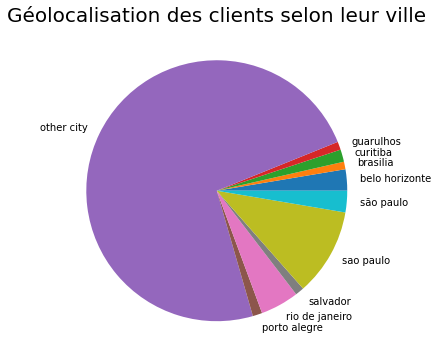

In [12]:
plt.figure(figsize=(15,6))

x= df_geolocation['geolocation_city'].value_counts()
x = x.groupby(np.where(x>=5000,x.index,'other city')).sum()
plt.pie(x,labels=x.index)
plt.title('Géolocalisation des clients selon leur ville', fontsize=20)

plt.show()

In [13]:
# données sur les articles achetés dans chaque commande
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
df_order_items.duplicated().sum() #nombre de doublon

0

In [15]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
df_order_items['shipping_limit_date']

0         2017-09-19 09:45:35
1         2017-05-03 11:05:13
2         2018-01-18 14:48:30
3         2018-08-15 10:10:18
4         2017-02-13 13:57:51
                 ...         
112645    2018-05-02 04:11:01
112646    2018-07-20 04:31:48
112647    2017-10-30 17:14:25
112648    2017-08-21 00:04:32
112649    2018-06-12 17:10:13
Name: shipping_limit_date, Length: 112650, dtype: object

In [17]:
df_order_items['price'].describe()
# min : 0.85 real brésilien  = 0.13 euro
# mediane : 74.99 real brésilien  = 11.39 euro
# moyenne : 120.65 real brésilien  = 18.32 euro
# max : 6735 real brésilien  = 567.46 euro

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

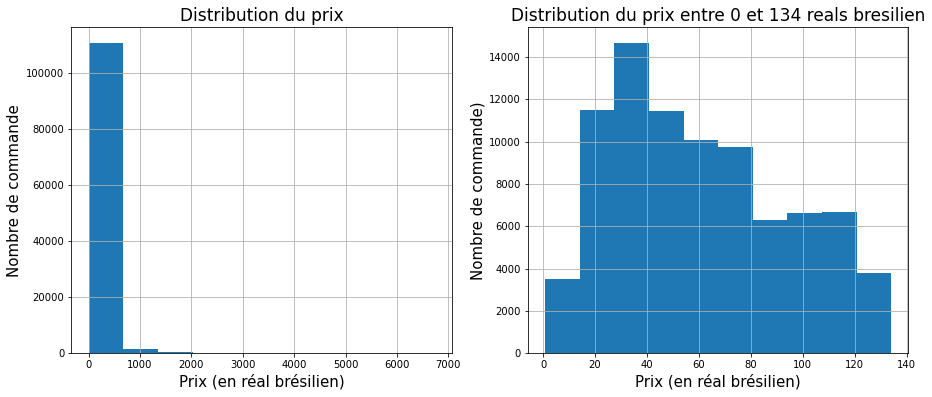

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
df_order_items['price'].hist()
plt.title('Distribution du prix', fontsize=17)
plt.xlabel('Prix (en réal brésilien)', fontsize=15)
plt.ylabel('Nombre de commande', fontsize=15)

plt.subplot(1,2,2)
df_order_items['price'][df_order_items['price'] < 134 ].hist() # 134 = 75% de la distribution
plt.title('Distribution du prix entre 0 et 134 reals bresilien', fontsize=17)
plt.xlabel('Prix (en réal brésilien)', fontsize=15)
plt.ylabel('Nombre de commande)', fontsize=15)

plt.show()

In [19]:
# données sur les options de paiement des commandes
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [20]:
df_order_payments.duplicated().sum() #nombre de doublon

0

In [21]:
df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [22]:
df_order_payments['payment_value'].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

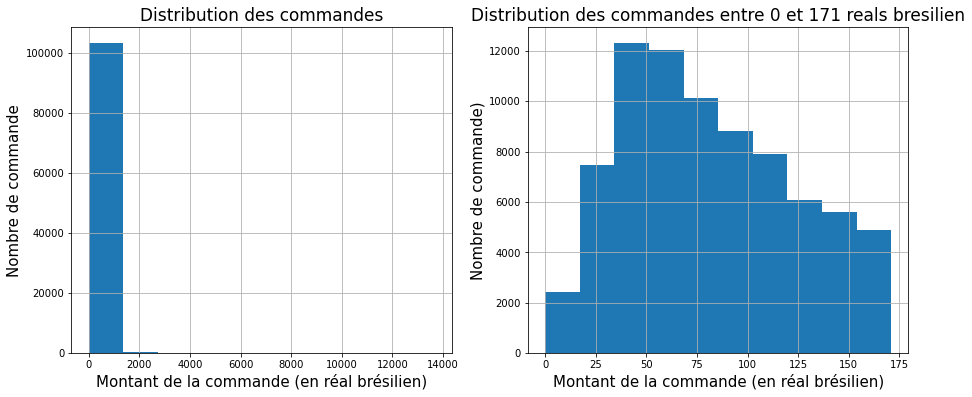

In [23]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
df_order_payments['payment_value'].hist()
plt.title('Distribution des commandes', fontsize=17)
plt.xlabel('Montant de la commande (en réal brésilien)', fontsize=15)
plt.ylabel('Nombre de commande', fontsize=15)

plt.subplot(1,2,2)
df_order_payments['payment_value'][df_order_payments['payment_value'] < 171 ].hist() # 171 reals brésiliens = 75% des commandes
plt.title('Distribution des commandes entre 0 et 171 reals bresilien', fontsize=17)
plt.xlabel('Montant de la commande (en réal brésilien)', fontsize=15)
plt.ylabel('Nombre de commande)', fontsize=15)



plt.show()

In [24]:
df_order_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [25]:
df_order_payments['payment_type'].value_counts()
# boleto : paiement en espèce
# voucher : paiement en bon d'achat

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

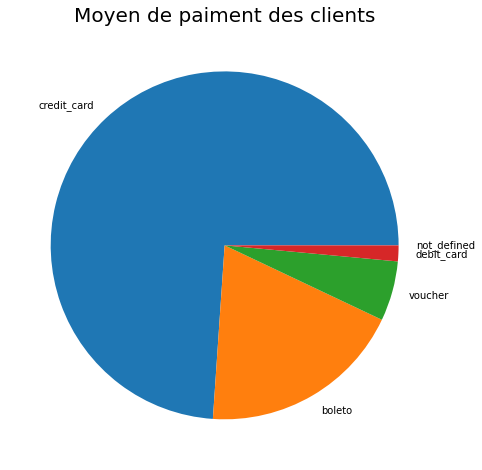

In [26]:
plt.figure(figsize=(15,8))

order_payments = df_order_payments['payment_type'].value_counts()
plt.pie(order_payments,labels=order_payments.index)
plt.title('Moyen de paiment des clients', fontsize=20)

plt.show()

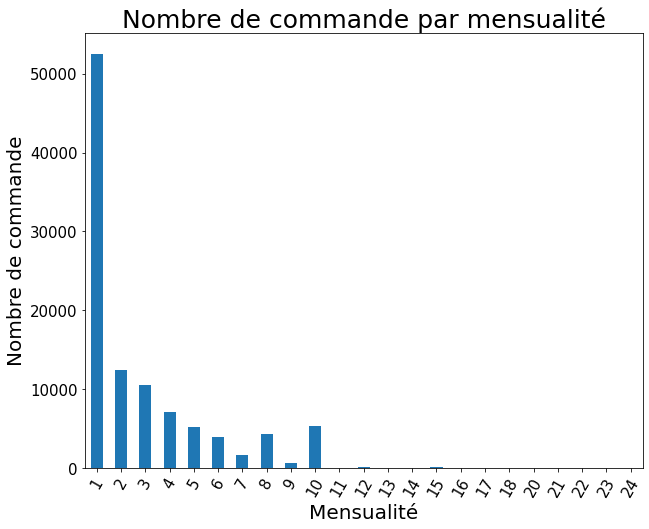

In [27]:
plt.figure(figsize=(10,8))
df_order_payments['payment_installments'].value_counts().sort_index()[1:].plot.bar()

plt.title("Nombre de commande par mensualité", fontsize=25)
plt.ylabel("Nombre de commande", fontsize=20)
plt.xlabel("Mensualité", fontsize=20)

degrees = 60
plt.xticks(rotation=degrees, fontsize=15)
plt.yticks(fontsize=15)


plt.show()

In [28]:
# données sur les avis des clients
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [29]:
df_order_reviews.duplicated().sum() #nombre de doublon

0

In [30]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [31]:
df_order_reviews.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [32]:
# classement des notes obtenues 
df_order_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

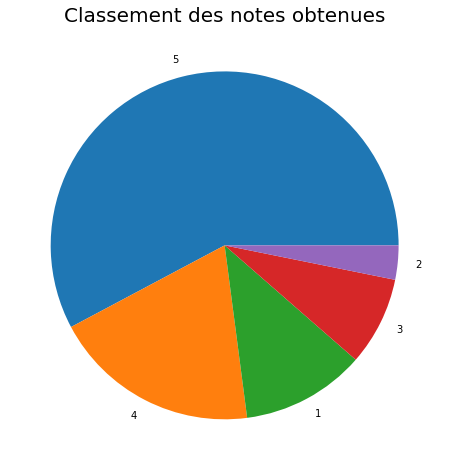

In [33]:
plt.figure(figsize=(15,8))

x= df_order_reviews['review_score'].value_counts()
plt.pie(x,labels=x.index)
plt.title('Classement des notes obtenues', fontsize=20)

plt.show()

Contrairement aux croyances populaires ('un client satisfait le dit à 3 personnes, un insatisfait à 9'), la majorité des notes octoyées ont été de 5, puis 4.
Les notes 1,2 et 3 cumulent à 3 environ 1/3 des notes

<Figure size 864x576 with 0 Axes>

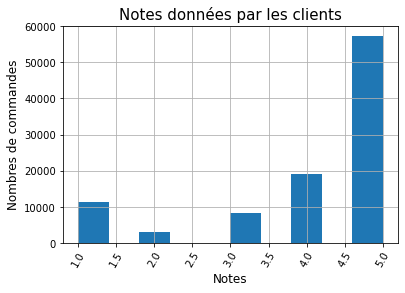

In [34]:
plt.figure(figsize=(12,8))

df_order_reviews.hist()

plt.title("Notes données par les clients", fontsize=15)
plt.xlabel("Notes", fontsize=12)
plt.ylabel("Nombres de commandes", fontsize=12)

degrees = 60
plt.xticks(rotation=degrees, fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [35]:
# données sur les commandes
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [36]:
df_order_payments['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
ee9ca989fc93ba09a6eddc250ce01742    19
                                    ..
cee9b5953fbfa530733f94ddce959a15     1
300a0fb67e14c56475f361381f629060     1
b21c9bac60c92e8b6ba770accf270445     1
50049a00b862d9b72dda26d6e7c38d6d     1
327511e31bd17e390fa2ce6ed4a64535     1
Name: order_id, Length: 99440, dtype: int64

In [37]:
df_orders.duplicated().sum() #nombre de doublon

0

In [38]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [39]:
df_orders['order_purchase_timestamp'] # horodate l'achat

0        2017-10-02 10:56:33
1        2018-07-24 20:41:37
2        2018-08-08 08:38:49
3        2017-11-18 19:28:06
4        2018-02-13 21:18:39
                ...         
99436    2017-03-09 09:54:05
99437    2018-02-06 12:58:58
99438    2017-08-27 14:46:43
99439    2018-01-08 21:28:27
99440    2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 99441, dtype: object

In [40]:
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

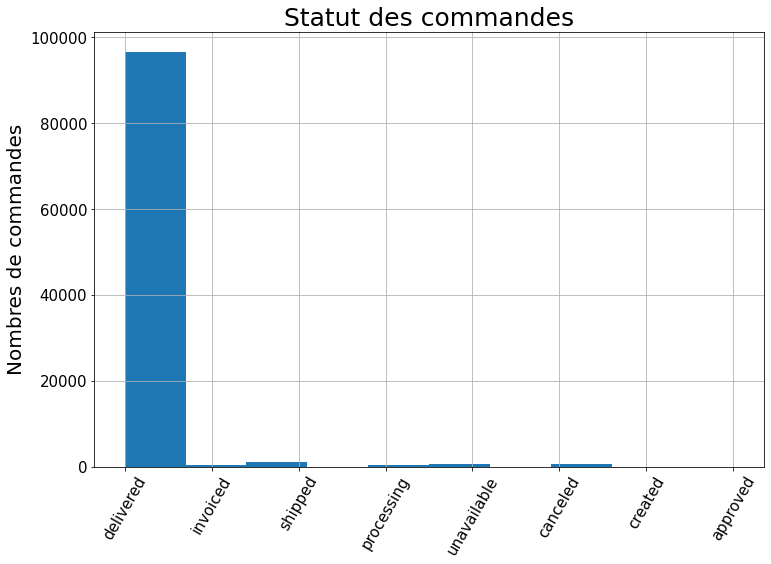

In [41]:
plt.figure(figsize=(12,8))

df_orders['order_status'].hist()

plt.title("Statut des commandes", fontsize=25)
plt.ylabel("Nombres de commandes", fontsize=20)

degrees = 60
plt.xticks(rotation=degrees, fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [42]:
df_orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [43]:
df_orders.describe()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,f7a6299376c602638dba07921850c6b8,f0413d0db87e22a35ae1cbdba85acb9d,delivered,2018-08-02 12:05:26,2018-02-27 04:31:10,2018-05-09 15:48:00,2016-10-27 17:32:07,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [44]:
# Transforme les strings en date pour pouvoir les manipuler

df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp']) 

In [45]:
df_orders['order_purchase_timestamp']

0       2017-10-02 10:56:33
1       2018-07-24 20:41:37
2       2018-08-08 08:38:49
3       2017-11-18 19:28:06
4       2018-02-13 21:18:39
                ...        
99436   2017-03-09 09:54:05
99437   2018-02-06 12:58:58
99438   2017-08-27 14:46:43
99439   2018-01-08 21:28:27
99440   2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 99441, dtype: datetime64[ns]

In [46]:
# données sur les produits vendus via Olist

df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [47]:
df_products.duplicated().sum() #nombre de doublon

0

In [48]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [49]:
# Données sur les vendeurs qui ont exécuté les commandes passées

df_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [50]:
df_sellers.duplicated().sum() #nombre de doublon

0

In [51]:
# traduit le nom de chaque catégorie de produits en anglais

df_product_category_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [52]:
df_product_category_name_translation.head(71)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


# REGROUPEMENT DES DATAFRAME

In [53]:
df2 = pd.merge(df_customers, df_orders, on='customer_id',)
df2.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [54]:
df2.duplicated().sum() #nombre de doublon

0

In [55]:
df3 = pd.merge(df2, df_order_items,on='order_id',)
df3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [56]:
df3.duplicated().sum() #nombre de doublon

0

In [57]:
df4 = pd.merge(df3, df_order_payments, on='order_id' )
df4.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25


In [58]:
df4.duplicated().sum() #nombre de doublon

0

In [59]:
df5 = pd.merge(df4, df_order_reviews, on='order_id')
df5.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1,credit_card,8,335.48,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1,credit_card,7,157.73,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1,credit_card,1,173.30,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1,credit_card,8,252.25,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52


In [60]:
df5.duplicated().sum() #nombre de doublon

0

In [61]:
df6 = pd.merge(df5, df_products, on='product_id')
df6.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,7fc63200f12eebb5f387856afdd63db8,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,7fc63200f12eebb5f387856afdd63db8,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,1,credit_card,7,140.61,251191809e37c1cffc16865947c18a4d,3,NaN,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,1,credit_card,10,137.58,f7123bac5b91a0e2e38d8b41fd1206f4,4,NaN,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


In [62]:
df6.duplicated().sum() #nombre de doublon

0

In [63]:
df7 = pd.merge(df6, df_product_category_name_translation, on='product_category_name')
df7.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,7fc63200f12eebb5f387856afdd63db8,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1,credit_card,1,275.79,7fc63200f12eebb5f387856afdd63db8,1,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,1,credit_card,7,140.61,251191809e37c1cffc16865947c18a4d,3,NaN,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,1,credit_card,10,137.58,f7123bac5b91a0e2e38d8b41fd1206f4,4,NaN,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture


In [64]:
df7.duplicated().sum() #nombre de doublon

0

In [65]:
df7.shape

(115609, 37)

In [66]:
df_feat_sel = df7.drop(['customer_zip_code_prefix', 'order_status','order_approved_at', 'order_delivered_carrier_date',
                        'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id','product_name_lenght',
                        'product_description_lenght', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                        'product_category_name', 'seller_id', 'shipping_limit_date', 'review_answer_timestamp', 
                        'review_comment_title', 'review_comment_message', 'review_creation_date' ], axis=1)
df_feat_sel.head()

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1,credit_card,2,146.87,4,1.0,8683.0,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,1,credit_card,1,275.79,1,1.0,8683.0,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,1,credit_card,1,275.79,1,1.0,8683.0,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,15.62,1,credit_card,7,140.61,3,1.0,8683.0,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,30.59,1,credit_card,10,137.58,4,1.0,8683.0,office_furniture


In [67]:
df_feat_sel.shape

(115609, 18)

In [68]:
def resumetable(df):
    '''
    Permet d'observer le types, le taux de nan, le nombre de valeur unique et les 3 premières valeurs de chaque features. 
    Affiche également les dimensions du dataframe.
    df:
       datframe sur lequel appliquer la fonction
    '''
    print(f"Les dimensions du dataframe : {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Nom'] = summary['index']
    summary = summary[['Nom','dtypes']]
    summary['Valeur manquante'] = df.isnull().mean().values    
    summary['Valeur unique'] = df.nunique().values
    summary['1ère valeur'] = df.loc[0].values
    summary['2ème valeur'] = df.loc[1].values
    summary['3ème valeur'] = df.loc[2].values

    
    return summary

In [69]:
resumetable(df_feat_sel)

Les dimensions du dataframe : (115609, 18)


,Nom,dtypes,Valeur manquante,Valeur unique,1ère valeur,2ème valeur,3ème valeur
0,customer_id,object,0.000000,96516,06b8999e2fba1a1fbc88172c00ba8bc7,8912fc0c3bbf1e2fbf35819e21706718,8912fc0c3bbf1e2fbf35819e21706718
1,customer_unique_id,object,0.000000,93396,861eff4711a542e4b93843c6dd7febb0,9eae34bbd3a474ec5d07949ca7de67c0,9eae34bbd3a474ec5d07949ca7de67c0
2,customer_city,object,0.000000,4093,franca,santarem,santarem
3,customer_state,object,0.000000,27,SP,PA,PA
4,order_id,object,0.000000,96516,00e7ee1b050b8499577073aeb2a297a1,c1d2b34febe9cd269e378117d6681172,c1d2b34febe9cd269e378117d6681172
5,order_purchase_timestamp,datetime64[ns],0.000000,95989,2017-05-16 15:05:35,2017-11-09 00:50:13,2017-11-09 00:50:13
6,order_item_id,int64,0.000000,21,1,1,2
7,product_id,object,0.000000,32171,a9516a079e37a9c9c36b9b78b10169e8,a9516a079e37a9c9c36b9b78b10169e8,a9516a079e37a9c9c36b9b78b10169e8
8,price,float64,0.000000,5879,124.99,112.99,112.99
9,freight_value,float64,0.000000,6954,21.88,24.9,24.9


Supressions des données manquantes

In [70]:
df_feat_sel.isna().mean()

customer_id                      0.000000
customer_unique_id               0.000000
customer_city                    0.000000
customer_state                   0.000000
order_id                         0.000000
order_purchase_timestamp         0.000000
order_item_id                    0.000000
product_id                       0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
review_score                     0.000000
product_photos_qty               0.000000
product_weight_g                 0.000009
product_category_name_english    0.000000
dtype: float64

In [71]:
def histogramm_for_nan(df):
    '''
    Permet d'afficher le taux de données manquanets par lignes et par colonnes.
    df:
       datframe sur lequel appliquer la fonction
    '''
    missing_col = df.isna().mean(axis=0)
    missing_row = df.isna().mean(axis=1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Taux de données manquantes')
    
    ax1.hist(missing_col)
    ax1.set_title('Par colonnes')
    ax1.set_xlabel('Taux de données manquantes')
    ax1.set_ylabel('Nombre de colonne')
    
    ax2.hist(missing_row)
    ax2.set_title('Par lignes')
    ax2.set_xlabel('Taux de données manquantes')
    ax2.set_ylabel('Nombre de lignes')
    
    plt.show()

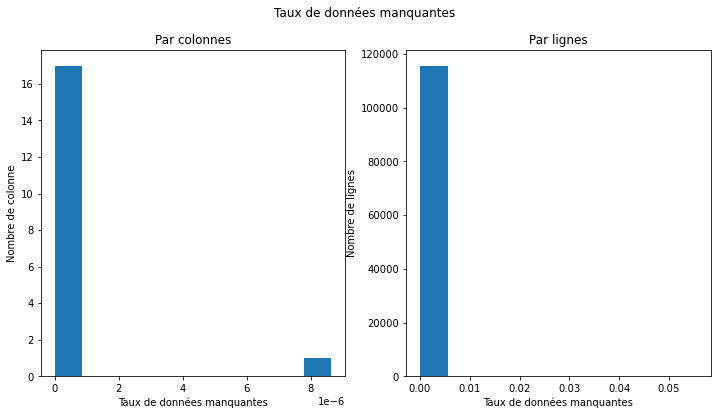

In [72]:
histogramm_for_nan(df_feat_sel)

# 2. FEATURE ENGINEERING

- Création de fetaure basé sur la segmentation RFM (Récence, Fréquence et Monétaire)
- Création de feature basé sur le ONE des fetures non numériqued

# Features basées sur la récence

- Avec 'recency', nous allons chercher la commande la plus réente du df.
- Nous allons ensuite calculer le delta en jours entre cette valeur et la commande la plus récente par customer
- Avec 'ancestry', nous ferons le calcul entre la commande la plus ancienne du df et la commande la plus ancienne par customer.

In [73]:
# recency 

most_recent_purchase_date = df_feat_sel['order_purchase_timestamp'].max()
most_recent_purchase_date

Timestamp('2018-09-03 09:06:57')

In [74]:
test = df_feat_sel.loc[df_feat_sel['customer_unique_id'] =='8d50f5eadf50201ccdcedfb9e2ac8455', 'order_purchase_timestamp']
test

14210    2018-05-22 23:08:55
14346    2017-11-22 20:01:53
14560    2018-05-21 22:44:31
14766    2018-08-07 23:32:14
16452    2017-06-18 22:56:48
16531    2017-07-24 22:11:50
17079    2018-07-23 21:53:02
17873    2018-08-18 12:39:19
17916    2017-05-15 23:30:03
18224    2017-10-18 23:25:04
18340    2017-09-05 22:14:52
101148   2017-07-18 23:10:58
101149   2017-10-29 16:58:02
101570   2018-07-04 22:35:13
108972   2018-08-20 19:14:26
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [75]:
test.max() 

Timestamp('2018-08-20 19:14:26')

In [76]:
last_date = test.max()

In [77]:
delta_date = last_date - most_recent_purchase_date

In [78]:
delta_date.days

-14

In [79]:
test = df_feat_sel.loc[df_feat_sel['customer_unique_id'] =='8d50f5eadf50201ccdcedfb9e2ac8455', :]
test

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_category_name_english
14210,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,6bdf325f0966e3056651285c0aed5aad,2018-05-22 23:08:55,1,d6354128c28cc56532ba7393d9373083,51.80,11.15,1,credit_card,1,62.95,5,1.0,1000.0,sports_leisure
14346,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,b850a16d8faf65a74c51287ef34379ce,2017-11-22 20:01:53,1,5bccc8fe44471df6c7b7e08176837d2f,13.99,7.78,1,credit_card,1,21.77,5,3.0,150.0,sports_leisure
14560,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,1,5cb96c51c55f57503465e4d2558dc053,45.99,7.39,1,credit_card,1,53.38,5,1.0,300.0,sports_leisure
14766,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,c2213109a2cc0e75d55585b7aaac6d97,2018-08-07 23:32:14,1,de7df82eb1e48c456b020c2cfb03aeed,26.99,7.45,1,credit_card,1,34.44,5,2.0,200.0,sports_leisure
16452,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,1,d83509907a19c72e1e4cdde78b8177ec,39.90,11.85,1,credit_card,2,51.75,5,2.0,200.0,sports_leisure
16531,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,bf92c69b7cc70f7fc2c37de43e366173,2017-07-24 22:11:50,1,e01bc2ad5c6f46c0f53f73379fcd602e,149.90,16.81,1,credit_card,3,166.71,5,4.0,900.0,sports_leisure
17079,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,1,41f6cb7c3b1200749326e50106f32d58,99.00,8.85,1,credit_card,1,107.85,5,2.0,330.0,sports_leisure
17873,3414a9c813e3ca02504b8be8b2deb27f,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,a1a6eadae352582010f449d8527b55f3,2018-08-18 12:39:19,1,426f910ccd39ae5e7d55013c466fe343,72.90,23.50,1,credit_card,2,96.40,5,1.0,350.0,sports_leisure
17916,0e4fdc084a6b9329ed55d62dcd653ccf,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,5d848f3d93a493c1c8955e018240e7ca,2017-05-15 23:30:03,1,4e1d2ef2974c85d82582edfe594a4f57,14.99,7.78,1,credit_card,1,22.77,5,4.0,300.0,sports_leisure
18224,89be66634d68fa73a95499b6352e085d,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,cd4b336a02aacabd0ef22f6db711f95e,2017-10-18 23:25:04,1,9169f70b7ce1138ac35678432d1e5ff2,29.99,7.78,1,credit_card,1,37.77,5,3.0,300.0,sports_leisure


In [80]:
test['order_purchase_timestamp'].max() 

Timestamp('2018-08-20 19:14:26')

In [81]:
last_date = test['order_purchase_timestamp'].max()

In [82]:
last_date

Timestamp('2018-08-20 19:14:26')

In [83]:
delta_date = last_date - most_recent_purchase_date

In [84]:
delta_date.days

-14

In [85]:
def recency(df_by_customer, most_recent_purchase_date): 
    ''' renvoi le nombre de jour entre la date d'achat la plus recente et la date d'achat la plus recente par customer
    Parameters:
        last_date (pandas.DataFrame): avec les dates d'achat pour un client au format DateTime
        most_recent_purchase_date (Timestamp): avec la date de la dernière commande du df
    Returns:   
        delta_date.days (int): difference en nombre de jour entre last_date et most_recent_purchase_date
    '''
    if df_by_customer.shape[0] == 1:
        last_date = df_by_customer['order_purchase_timestamp'].iloc[0] # certaines fois on a une valeur et d'autres fois une Série
    else:
        last_date = df_by_customer['order_purchase_timestamp'].max()
    delta_date = most_recent_purchase_date - last_date
    
    return delta_date.days

In [86]:
df_recency = df_feat_sel[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency.name = 'recency'
df_recency = pd.DataFrame(df_recency)
df_recency

,recency
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,115
0000b849f77a49e4a4ce2b2a4ca5be3f,118
0000f46a3911fa3c0805444483337064,541
0000f6ccb0745a6a4b88665a16c9f078,325
0004aac84e0df4da2b147fca70cf8255,292
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451
fffea47cd6d3cc0a88bd621562a9d061,266
ffff371b4d645b6ecea244b27531430a,572


array([[<AxesSubplot:title={'center':'recency'}>]], dtype=object)

<Figure size 720x576 with 0 Axes>

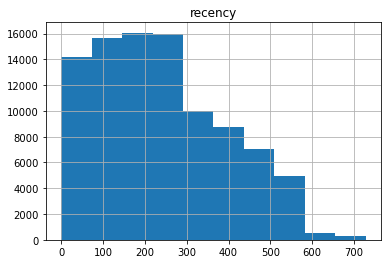

In [87]:
plt.figure(figsize=(10,8))
df_recency.hist()

In [88]:
# ancestry
most_old_purchase_date = df_feat_sel['order_purchase_timestamp'].min()
most_old_purchase_date

Timestamp('2016-09-04 21:15:19')

In [89]:
test2 = df_feat_sel.loc[df_feat_sel['customer_unique_id'] =='8d50f5eadf50201ccdcedfb9e2ac8455', :]
test2

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_category_name_english
14210,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,6bdf325f0966e3056651285c0aed5aad,2018-05-22 23:08:55,1,d6354128c28cc56532ba7393d9373083,51.80,11.15,1,credit_card,1,62.95,5,1.0,1000.0,sports_leisure
14346,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,b850a16d8faf65a74c51287ef34379ce,2017-11-22 20:01:53,1,5bccc8fe44471df6c7b7e08176837d2f,13.99,7.78,1,credit_card,1,21.77,5,3.0,150.0,sports_leisure
14560,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,1,5cb96c51c55f57503465e4d2558dc053,45.99,7.39,1,credit_card,1,53.38,5,1.0,300.0,sports_leisure
14766,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,c2213109a2cc0e75d55585b7aaac6d97,2018-08-07 23:32:14,1,de7df82eb1e48c456b020c2cfb03aeed,26.99,7.45,1,credit_card,1,34.44,5,2.0,200.0,sports_leisure
16452,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,1,d83509907a19c72e1e4cdde78b8177ec,39.90,11.85,1,credit_card,2,51.75,5,2.0,200.0,sports_leisure
16531,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,bf92c69b7cc70f7fc2c37de43e366173,2017-07-24 22:11:50,1,e01bc2ad5c6f46c0f53f73379fcd602e,149.90,16.81,1,credit_card,3,166.71,5,4.0,900.0,sports_leisure
17079,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,1,41f6cb7c3b1200749326e50106f32d58,99.00,8.85,1,credit_card,1,107.85,5,2.0,330.0,sports_leisure
17873,3414a9c813e3ca02504b8be8b2deb27f,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,a1a6eadae352582010f449d8527b55f3,2018-08-18 12:39:19,1,426f910ccd39ae5e7d55013c466fe343,72.90,23.50,1,credit_card,2,96.40,5,1.0,350.0,sports_leisure
17916,0e4fdc084a6b9329ed55d62dcd653ccf,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,5d848f3d93a493c1c8955e018240e7ca,2017-05-15 23:30:03,1,4e1d2ef2974c85d82582edfe594a4f57,14.99,7.78,1,credit_card,1,22.77,5,4.0,300.0,sports_leisure
18224,89be66634d68fa73a95499b6352e085d,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP,cd4b336a02aacabd0ef22f6db711f95e,2017-10-18 23:25:04,1,9169f70b7ce1138ac35678432d1e5ff2,29.99,7.78,1,credit_card,1,37.77,5,3.0,300.0,sports_leisure


In [90]:
test2['order_purchase_timestamp'].min() 

Timestamp('2017-05-15 23:30:03')

In [91]:
old_date = test2['order_purchase_timestamp'].min()
old_date

Timestamp('2017-05-15 23:30:03')

In [92]:
delta_date = old_date - most_old_purchase_date
delta_date

Timedelta('253 days 02:14:44')

In [93]:
def ancestry(df_by_customer, most_old_purchase_date): 
    ''' renvoi le nombre de jour entre la date d'achat la plus ancienne et la date d'achat la plus ancienne par customer
    Parameters:
        last_date (pandas.DataFrame): avec les dates d'achat pour un client au format DateTime
        most_old_purchase_date (Timestamp): avec la date de la dernière commande du df
    Returns:   
        delta_date.days (int): difference en nombre de jour entre last_date et most_recent_purchase_date
    '''
    if df_by_customer.shape[0] == 1:
        old_date = df_by_customer['order_purchase_timestamp'].iloc[0] # certaines fois on a une valeur et d'autres fois une Série
    else:
        old_date = df_by_customer['order_purchase_timestamp'].min()
    delta_date =  old_date - most_old_purchase_date
    return delta_date.days

In [94]:
df_ancestry = df_feat_sel[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry.name = 'ancestry'
df_ancestry = pd.DataFrame(df_ancestry)
df_ancestry

,ancestry
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,612
0000b849f77a49e4a4ce2b2a4ca5be3f,609
0000f46a3911fa3c0805444483337064,186
0000f6ccb0745a6a4b88665a16c9f078,402
0004aac84e0df4da2b147fca70cf8255,435
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,276
fffea47cd6d3cc0a88bd621562a9d061,461
ffff371b4d645b6ecea244b27531430a,155


# Features de fréquence

In [95]:
# Nombre de commande passée par chaque client unique

df_frequency = df_feat_sel[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency.name = 'frequency'
df_frequency = pd.DataFrame(df_frequency)
df_frequency

,frequency
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,15
3e43e6105506432c953e165fb2acf44c,9
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...
564ab8ca31faaf89e0ce856cfd7472a6,1
56499d19a0dfa7e0219fe765cfe6f1c6,1
564988508a81dca36512b04a1ce906f9,1


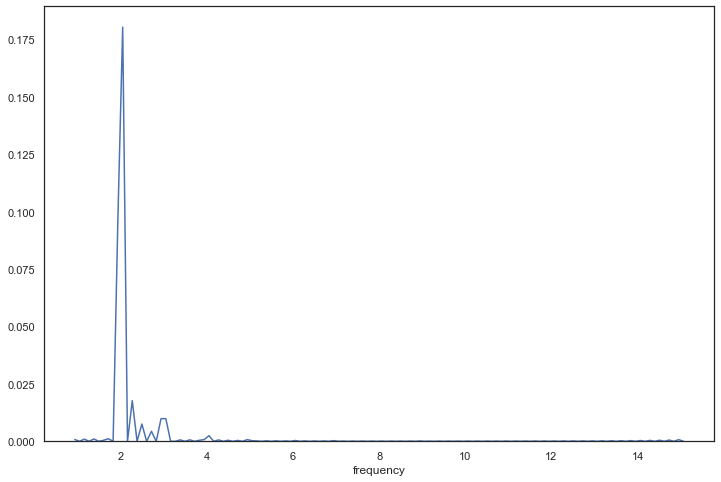

In [96]:
# visualisation de la distribution de la fréquence d'achat

sns.set(style='white')
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(df_frequency['frequency'], hist=False)
plt.show()

# Features monétaires

In [97]:
# Cout median de chaque commande par client unique

df_monetary_value = df_feat_sel[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['median'])
df_monetary_value.columns = df_monetary_value.columns.get_level_values(1)
df_monetary_value.columns = ['payment_' + col for col in df_monetary_value.columns]
df_monetary_value

,payment_median
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0000f46a3911fa3c0805444483337064,86.22
0000f6ccb0745a6a4b88665a16c9f078,43.62
0004aac84e0df4da2b147fca70cf8255,196.89
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
fffea47cd6d3cc0a88bd621562a9d061,84.58
ffff371b4d645b6ecea244b27531430a,112.46


# Autres features axé sur les clients

In [98]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par chaque client unique

df_review = df_feat_sel.groupby(['customer_unique_id']).agg({ 'review_score' : ['median']})
df_review.columns = df_review.columns.get_level_values(1)
df_review.columns = ['review_' + col for col in df_review.columns]
df_review

,review_median
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


# 3. AGREGATION DES FEATURES

In [99]:
df = pd.merge(df_recency,df_ancestry,  on='customer_unique_id')
df.shape

(93396, 2)

In [100]:
df = pd.merge(df, df_frequency,  on='customer_unique_id')

In [101]:
df = pd.merge(df, df_monetary_value, on='customer_unique_id')

In [102]:
df = pd.merge(df, df_review,  on='customer_unique_id')

In [103]:
df

,recency,ancestry,frequency,payment_median,review_median
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,612,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,609,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,186,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,325,402,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,292,435,1,196.89,5.0
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451,276,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,266,461,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,572,155,1,112.46,5.0


In [104]:
df.describe()

,recency,ancestry,frequency,payment_median,review_median
count,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,241.744250,482.859148,1.033406,158.582579,4.104078
std,153.164721,153.664622,0.208235,217.640857,1.327166
min,0.000000,0.000000,1.000000,0.250000,1.000000
25%,118.000000,373.000000,1.000000,60.750000,4.000000
50%,222.000000,502.000000,1.000000,103.550000,5.000000
75%,351.000000,608.000000,1.000000,175.572500,5.000000
max,728.000000,723.000000,15.000000,13664.080000,5.000000


Nombre de clients type: 22571
Nombre de clients fréquents: 2807
Nombre de bons clients : 5934
Nombre de clients à ne pas cibler : 5855
Nombre de clients VIP: 101
Nombre de clients perdus: 18


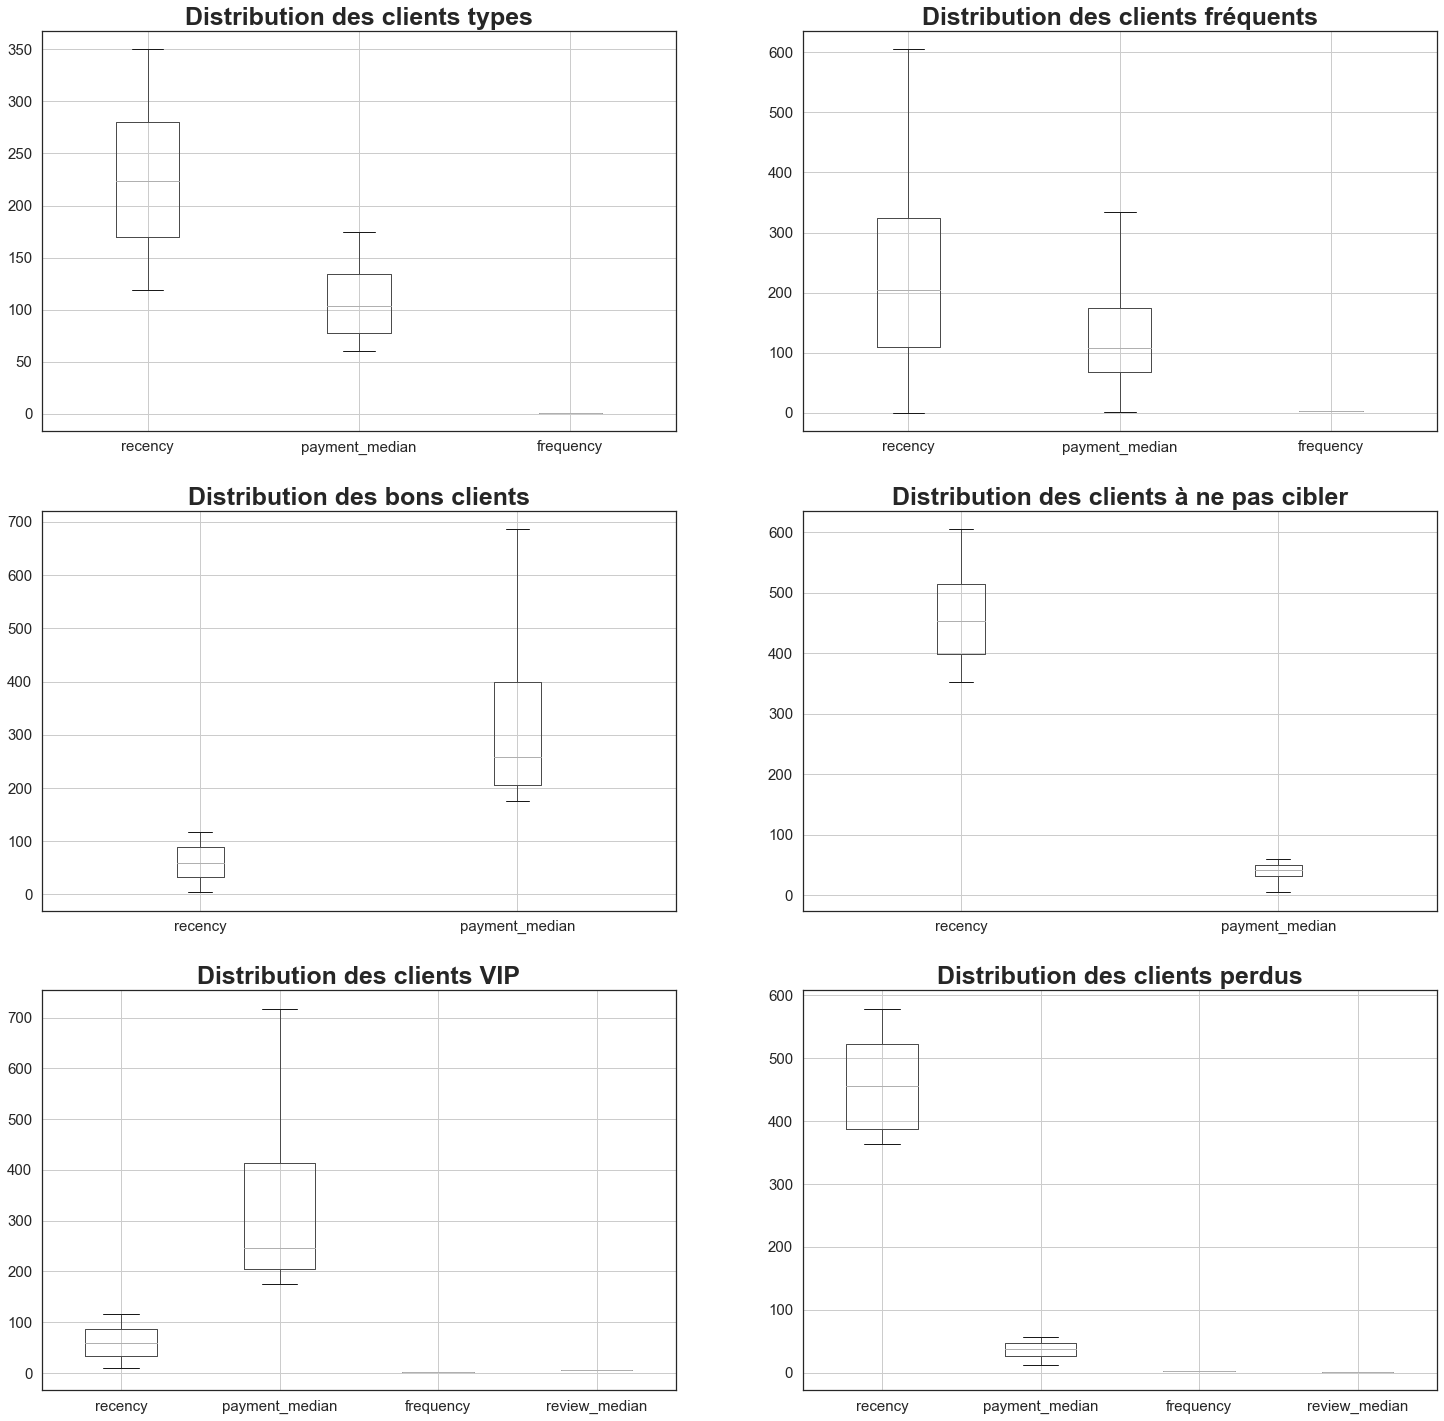

In [105]:
# Segments de clients

# clients types : clients dans les 2èmes et 3èmes quartiles de la RFM
Typical_Customer =  df.loc[(df['recency'] > 118) & (df['recency'] < 351) 
                         & (df['frequency'] == 1) 
                         & (df['payment_median'] > 60) & (df['payment_median'] < 175)] 

# Frequence
Frequent_customer = df[df['frequency'] > 1] # clients avec un minimum de 2 achats différents

# Bons clients : clients avec de grosses dépenses et recents
Good_customer = df.loc[(df['payment_median'] > 175) & (df['recency'] < 118)] 

# Clients à ne pas cibler : clients avec de faibles dépenses et anciens
Not_targetable_customer =  df.loc[(df['payment_median'] < 60) & (df['recency'] > 351)] 


# VIP :  clients avec de grosses dépenses, recent, fidèles, et satisfait 
VIP_customer =  df.loc[(df['payment_median'] > 175) & (df['recency'] < 118) & (df['frequency'] > 1) 
                       & (df['review_median'] == 5)] 

# Clients perdus : clients avec de faibles dépenses, anciens, pas fidèles et insatisfaits
Lost_customer = df.loc[(df['payment_median'] < 60) & (df['recency'] > 351) & (df['frequency'] > 1) 
                       & (df['review_median'] < 3)] 

print('Nombre de clients type:', Typical_Customer['frequency'].count())
print('Nombre de clients fréquents:', Frequent_customer['frequency'].count())
print('Nombre de bons clients :', Good_customer['payment_median'].count())
print("Nombre de clients à ne pas cibler :", Not_targetable_customer['payment_median'].count())
print('Nombre de clients VIP:', VIP_customer['payment_median'].count())
print('Nombre de clients perdus:', Lost_customer['payment_median'].count())

plt.figure(figsize=(25,25))

plt.subplot(3,2,1)
Typical_Customer = Typical_Customer[['recency', 'payment_median', 'frequency']]
Typical_Customer.boxplot(showfliers=False)
plt.title('Distribution des clients types', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15,)
plt.xticks(fontsize=15)

plt.subplot(3,2,2)
Frequent_customer = Frequent_customer[['recency', 'payment_median', 'frequency']]
Frequent_customer.boxplot(showfliers=False)
plt.title('Distribution des clients fréquents', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15,)
plt.xticks(fontsize=15)

plt.subplot(3,2,3)
Good_customer = Good_customer[['recency', 'payment_median']]
Good_customer.boxplot(showfliers=False)
plt.title('Distribution des bons clients', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,4)
Not_targetable_customer = Not_targetable_customer[['recency', 'payment_median']]
Not_targetable_customer.boxplot(showfliers=False)
plt.title('Distribution des clients à ne pas cibler', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,5)
VIP_customer = VIP_customer[['recency', 'payment_median', 'frequency', 'review_median']]
VIP_customer.boxplot(showfliers=False)
plt.title('Distribution des clients VIP', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(3,2,6)
Lost_customer = Lost_customer[['recency', 'payment_median', 'frequency', 'review_median']]
Lost_customer.boxplot(showfliers=False)
plt.title('Distribution des clients perdus', fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.show()

- les bons clients types et les clients VIP ont des dépenses  plus importantes que la moyenne et ont commandé dans les 3 derniers mois
- les clients à ne pas cibler et les clients perdus ont des moneant de commande peu élevés et n'ont pas commandé depuis plus d'un an
- les clients types et les clients fréquents ont des dépense et une ancienneté qui se situent entre ces 2 groupes

<AxesSubplot:>

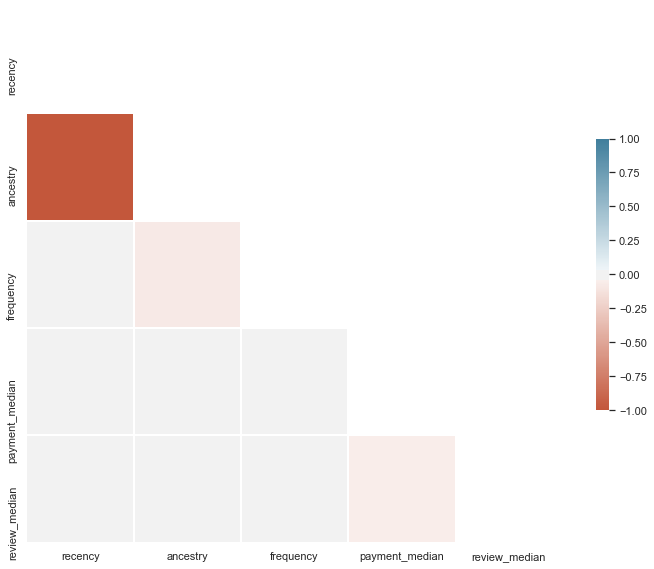

In [106]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [107]:
# Suppression des features trop corrélées
df = df.drop(['ancestry'], axis=1)
df.shape

(93396, 4)

<AxesSubplot:>

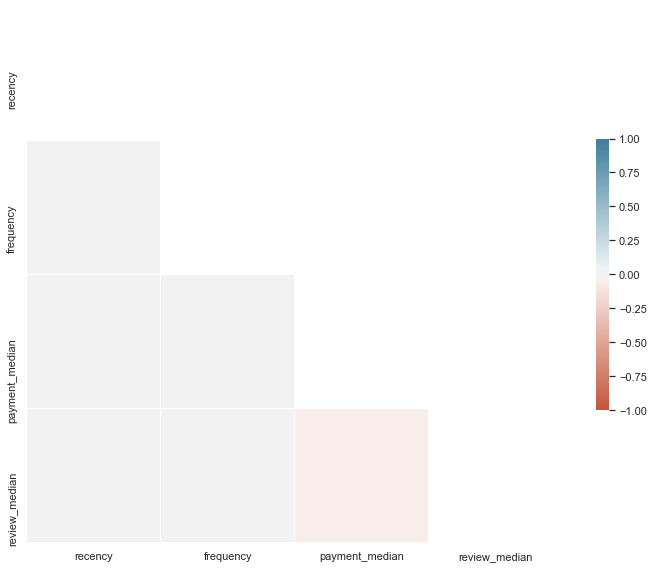

In [108]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [109]:
df

,recency,frequency,payment_median,review_median
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,572,1,112.46,5.0


In [110]:
# enregistrement du dataframe
df.to_csv('df_rfm.csv', index= None)

In [299]:
df.shape

(93396, 4)

# 5. SEPARATION DU DATAFRAME EN 6 PARTIES

Nous allons divisier le dataframe en 6 parties. Lors de la modelisation ces df serviront de benchmark, ce qui permet de découvrir à quelle fréquence il faut mettre à jour le modèle pour le contrat de maintenance.
Nous allons diviser le dataframe en :

- 1 mois de données
- 3 mois de données
- 6 mois de données
- 9 mois de données
- 12 mois de données
- 24 mois de données (dataframe entier)

In [112]:
# Date de la première commande
df_feat_sel['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [113]:
# Date de la dernière commande
df_feat_sel['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

# 1 mois 

## Features basées sur la récence

In [114]:
# 1 mois
df_1_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2016-10-04', :]
df_1_months.shape

(12, 18)

In [115]:
df_1_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [116]:
df_1_months['order_purchase_timestamp'].max()

Timestamp('2016-10-03 22:51:30')

In [117]:
# recency 

most_recent_purchase_date_1_months = df_1_months['order_purchase_timestamp'].max()
most_recent_purchase_date_1_months

Timestamp('2016-10-03 22:51:30')

In [118]:
df_recency_1_months = df_1_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_1_months.name = 'recency'
df_recency_1_months = pd.DataFrame(df_recency_1_months)
df_recency_1_months

,recency
customer_unique_id,
0eb1ee9dba87f5b36b4613a65074337c,700
10e89fd8e5c745f81bec101207ba4d7d,699
2f64e403852e6893ae37485d5fcacdaf,699
32ea3bdedab835c3aa6cb68ce66565ef,699
4854e9b3feff728c13ee5fc7d1547e92,728
61db744d2f835035a5625b59350c6b63,699
7390ed59fa1febbfda31a80b4318c8cb,699
87776adb449c551e74c13fc34f036105,699
8d3a54507421dbd2ce0a1d58046826e0,699


In [119]:
# ancestry
most_old_purchase_date_1_months = df_1_months['order_purchase_timestamp'].min()
most_old_purchase_date_1_months

Timestamp('2016-09-04 21:15:19')

In [120]:
df_ancestry_1_months = df_1_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_1_months.name = 'ancestry'
df_ancestry_1_months = pd.DataFrame(df_ancestry_1_months)
df_ancestry_1_months

,ancestry
customer_unique_id,
0eb1ee9dba87f5b36b4613a65074337c,28
10e89fd8e5c745f81bec101207ba4d7d,29
2f64e403852e6893ae37485d5fcacdaf,28
32ea3bdedab835c3aa6cb68ce66565ef,28
4854e9b3feff728c13ee5fc7d1547e92,0
61db744d2f835035a5625b59350c6b63,28
7390ed59fa1febbfda31a80b4318c8cb,29
87776adb449c551e74c13fc34f036105,29
8d3a54507421dbd2ce0a1d58046826e0,29


# Features de fréquence

In [121]:
# Nombre de commande passée par chaque client unique

df_frequency_1_months = df_1_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_1_months.name = 'frequency'
df_frequency_1_months = pd.DataFrame(df_frequency_1_months)
df_frequency_1_months

,frequency
customer_unique_id,
0eb1ee9dba87f5b36b4613a65074337c,1
10e89fd8e5c745f81bec101207ba4d7d,1
2f64e403852e6893ae37485d5fcacdaf,1
32ea3bdedab835c3aa6cb68ce66565ef,1
4854e9b3feff728c13ee5fc7d1547e92,1
61db744d2f835035a5625b59350c6b63,1
7390ed59fa1febbfda31a80b4318c8cb,1
87776adb449c551e74c13fc34f036105,1
8d3a54507421dbd2ce0a1d58046826e0,1


# Features monétaires

In [122]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_1_months = df_1_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_1_months.columns = df_monetary_value_1_months.columns.get_level_values(1)
df_monetary_value_1_months.columns = ['payment_' + col for col in df_monetary_value_1_months.columns]
df_monetary_value_1_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,109.34,109.34,109.34,109.34
10e89fd8e5c745f81bec101207ba4d7d,92.27,92.27,92.27,92.27
2f64e403852e6893ae37485d5fcacdaf,39.09,39.09,39.09,39.09
32ea3bdedab835c3aa6cb68ce66565ef,45.46,45.46,45.46,45.46
4854e9b3feff728c13ee5fc7d1547e92,75.06,75.06,75.06,75.06
61db744d2f835035a5625b59350c6b63,53.73,53.73,53.73,53.73
7390ed59fa1febbfda31a80b4318c8cb,154.57,154.57,154.57,154.57
87776adb449c551e74c13fc34f036105,40.95,40.95,40.95,40.95
8d3a54507421dbd2ce0a1d58046826e0,133.46,133.46,133.46,133.46


In [123]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_1_months = df_1_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_1_months.columns = df_price_1_months.columns.get_level_values(1)
df_price_1_months.columns = ['price_' + col for col in df_price_1_months.columns]
df_price_1_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,100.00,100.00,100.000,100.000
10e89fd8e5c745f81bec101207ba4d7d,74.90,74.90,74.900,74.900
2f64e403852e6893ae37485d5fcacdaf,21.90,21.90,21.900,21.900
32ea3bdedab835c3aa6cb68ce66565ef,29.90,29.90,29.900,29.900
4854e9b3feff728c13ee5fc7d1547e92,59.50,59.50,59.500,59.500
61db744d2f835035a5625b59350c6b63,36.49,36.49,36.490,36.490
7390ed59fa1febbfda31a80b4318c8cb,128.90,128.90,128.900,128.900
87776adb449c551e74c13fc34f036105,29.99,29.99,29.990,29.990
8d3a54507421dbd2ce0a1d58046826e0,119.90,119.90,119.900,119.900


In [124]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_1_months = df_1_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_1_months.columns = df_installments_1_months.columns.get_level_values(1)
df_installments_1_months.columns = ['installments_' + col for col in df_installments_1_months.columns]
df_installments_1_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,1,1,1,1
10e89fd8e5c745f81bec101207ba4d7d,3,3,3,3
2f64e403852e6893ae37485d5fcacdaf,1,1,1,1
32ea3bdedab835c3aa6cb68ce66565ef,1,1,1,1
4854e9b3feff728c13ee5fc7d1547e92,3,3,3,3
61db744d2f835035a5625b59350c6b63,1,1,1,1
7390ed59fa1febbfda31a80b4318c8cb,2,2,2,2
87776adb449c551e74c13fc34f036105,4,4,4,4
8d3a54507421dbd2ce0a1d58046826e0,6,6,6,6


In [125]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_1_months = df_1_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_1_months.columns = df_freight_value_1_months.columns.get_level_values(1)
df_freight_value_1_months.columns = ['freight_value_' + col for col in df_freight_value_1_months.columns]
df_freight_value_1_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,9.34,9.34,9.34,9.34
10e89fd8e5c745f81bec101207ba4d7d,17.37,17.37,17.37,17.37
2f64e403852e6893ae37485d5fcacdaf,17.19,17.19,17.19,17.19
32ea3bdedab835c3aa6cb68ce66565ef,15.56,15.56,15.56,15.56
4854e9b3feff728c13ee5fc7d1547e92,15.56,15.56,15.56,15.56
61db744d2f835035a5625b59350c6b63,17.24,17.24,17.24,17.24
7390ed59fa1febbfda31a80b4318c8cb,25.67,25.67,25.67,25.67
87776adb449c551e74c13fc34f036105,10.96,10.96,10.96,10.96
8d3a54507421dbd2ce0a1d58046826e0,13.56,13.56,13.56,13.56


# Autres features axé sur les clients

In [126]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_1_months = df_1_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_1_months.columns = df_review_1_months.columns.get_level_values(1)
df_review_1_months.columns = ['review_' + col for col in df_review_1_months.columns]
df_review_1_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,1,1,1,1
10e89fd8e5c745f81bec101207ba4d7d,1,1,1,1
2f64e403852e6893ae37485d5fcacdaf,4,4,4,4
32ea3bdedab835c3aa6cb68ce66565ef,4,4,4,4
4854e9b3feff728c13ee5fc7d1547e92,1,1,1,1
61db744d2f835035a5625b59350c6b63,3,3,3,3
7390ed59fa1febbfda31a80b4318c8cb,5,5,5,5
87776adb449c551e74c13fc34f036105,5,5,5,5
8d3a54507421dbd2ce0a1d58046826e0,1,1,1,1


In [127]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_1_months = df_1_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_1_months.columns = df_photos_1_months.columns.get_level_values(1)
df_photos_1_months.columns = ['photos_qty_' + col for col in df_photos_1_months.columns]
df_photos_1_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
0eb1ee9dba87f5b36b4613a65074337c,1.0,1.0,1.0,1.0
10e89fd8e5c745f81bec101207ba4d7d,1.0,1.0,1.0,1.0
2f64e403852e6893ae37485d5fcacdaf,1.0,1.0,1.0,1.0
32ea3bdedab835c3aa6cb68ce66565ef,3.0,3.0,3.0,3.0
4854e9b3feff728c13ee5fc7d1547e92,1.0,1.0,1.0,1.0
61db744d2f835035a5625b59350c6b63,1.0,1.0,1.0,1.0
7390ed59fa1febbfda31a80b4318c8cb,1.0,1.0,1.0,1.0
87776adb449c551e74c13fc34f036105,2.0,2.0,2.0,2.0
8d3a54507421dbd2ce0a1d58046826e0,1.0,1.0,1.0,1.0


In [128]:
# Nombre de régions  différentes par client

df_cust_state_1_months = df_1_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_1_months

,customer_state
customer_unique_id,
0eb1ee9dba87f5b36b4613a65074337c,1
10e89fd8e5c745f81bec101207ba4d7d,1
2f64e403852e6893ae37485d5fcacdaf,1
32ea3bdedab835c3aa6cb68ce66565ef,1
4854e9b3feff728c13ee5fc7d1547e92,1
61db744d2f835035a5625b59350c6b63,1
7390ed59fa1febbfda31a80b4318c8cb,1
87776adb449c551e74c13fc34f036105,1
8d3a54507421dbd2ce0a1d58046826e0,1


In [129]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_1_months = df_cust_state_1_months.loc[df_cust_state_1_months['customer_state']>1]
df_custom_multi_state_1_months

,customer_state
customer_unique_id,
b7d76e111c89f7ebf14761390f0f7d17,2


In [130]:
# Sélectionner la première région pour chaquee client dans le dataframe pour du One Hot Encoding

df_custom_single_state_1_months = df_1_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_1_months 

,customer_unique_id,customer_state
12458,b8b8726af116a5cfb35b0315ecef9172,RJ
13116,61db744d2f835035a5625b59350c6b63,RS
17354,2f64e403852e6893ae37485d5fcacdaf,RS
29215,7390ed59fa1febbfda31a80b4318c8cb,GO
32520,b7d76e111c89f7ebf14761390f0f7d17,RR
38327,8d3a54507421dbd2ce0a1d58046826e0,SP
38452,10e89fd8e5c745f81bec101207ba4d7d,MG
48730,4854e9b3feff728c13ee5fc7d1547e92,RS
68622,0eb1ee9dba87f5b36b4613a65074337c,SP
85856,32ea3bdedab835c3aa6cb68ce66565ef,SP


# AGREGATION DES FEATURES

In [131]:
# Affiche les dimensions pour voir si le df va perdre les lignes non contenu dans les df axés clients

df_1_months.shape 

(12, 18)

In [132]:
df_1_months = pd.merge(df_recency_1_months,df_ancestry_1_months,  on='customer_unique_id')
df_1_months.shape

(11, 2)

In [133]:
df_1_months = pd.merge(df_1_months, df_frequency_1_months,  on='customer_unique_id')

In [134]:
df_1_months = pd.merge(df_1_months, df_monetary_value_1_months, on='customer_unique_id')

In [135]:
df_1_months = pd.merge(df_1_months, df_price_1_months,  on='customer_unique_id')

In [136]:
df_1_months = pd.merge(df_1_months, df_installments_1_months,  on='customer_unique_id')

In [137]:
df_1_months = pd.merge(df_1_months, df_freight_value_1_months,  on='customer_unique_id')

In [138]:
df_1_months = pd.merge(df_1_months, df_review_1_months,  on='customer_unique_id')

In [139]:
df_1_months = pd.merge(df_1_months, df_photos_1_months,  on='customer_unique_id')
df_1_months.shape

(11, 27)

In [140]:
df_1_months

,recency,ancestry,frequency,payment_min,payment_max,payment_mean,payment_median,price_min,price_max,price_median,price_mean,installments_min,installments_max,installments_median,installments_mean,freight_value_min,freight_value_max,freight_value_median,freight_value_mean,review_min,review_max,review_median,review_mean,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0eb1ee9dba87f5b36b4613a65074337c,700,28,1,109.34,109.34,109.34,109.34,100.00,100.00,100.000,100.000,1,1,1,1,9.34,9.34,9.34,9.34,1,1,1,1,1.0,1.0,1.0,1.0
10e89fd8e5c745f81bec101207ba4d7d,699,29,1,92.27,92.27,92.27,92.27,74.90,74.90,74.900,74.900,3,3,3,3,17.37,17.37,17.37,17.37,1,1,1,1,1.0,1.0,1.0,1.0
2f64e403852e6893ae37485d5fcacdaf,699,28,1,39.09,39.09,39.09,39.09,21.90,21.90,21.900,21.900,1,1,1,1,17.19,17.19,17.19,17.19,4,4,4,4,1.0,1.0,1.0,1.0
32ea3bdedab835c3aa6cb68ce66565ef,699,28,1,45.46,45.46,45.46,45.46,29.90,29.90,29.900,29.900,1,1,1,1,15.56,15.56,15.56,15.56,4,4,4,4,3.0,3.0,3.0,3.0
4854e9b3feff728c13ee5fc7d1547e92,728,0,1,75.06,75.06,75.06,75.06,59.50,59.50,59.500,59.500,3,3,3,3,15.56,15.56,15.56,15.56,1,1,1,1,1.0,1.0,1.0,1.0
61db744d2f835035a5625b59350c6b63,699,28,1,53.73,53.73,53.73,53.73,36.49,36.49,36.490,36.490,1,1,1,1,17.24,17.24,17.24,17.24,3,3,3,3,1.0,1.0,1.0,1.0
7390ed59fa1febbfda31a80b4318c8cb,699,29,1,154.57,154.57,154.57,154.57,128.90,128.90,128.900,128.900,2,2,2,2,25.67,25.67,25.67,25.67,5,5,5,5,1.0,1.0,1.0,1.0
87776adb449c551e74c13fc34f036105,699,29,1,40.95,40.95,40.95,40.95,29.99,29.99,29.990,29.990,4,4,4,4,10.96,10.96,10.96,10.96,5,5,5,5,2.0,2.0,2.0,2.0
8d3a54507421dbd2ce0a1d58046826e0,699,29,1,133.46,133.46,133.46,133.46,119.90,119.90,119.900,119.900,6,6,6,6,13.56,13.56,13.56,13.56,1,1,1,1,1.0,1.0,1.0,1.0


<AxesSubplot:>

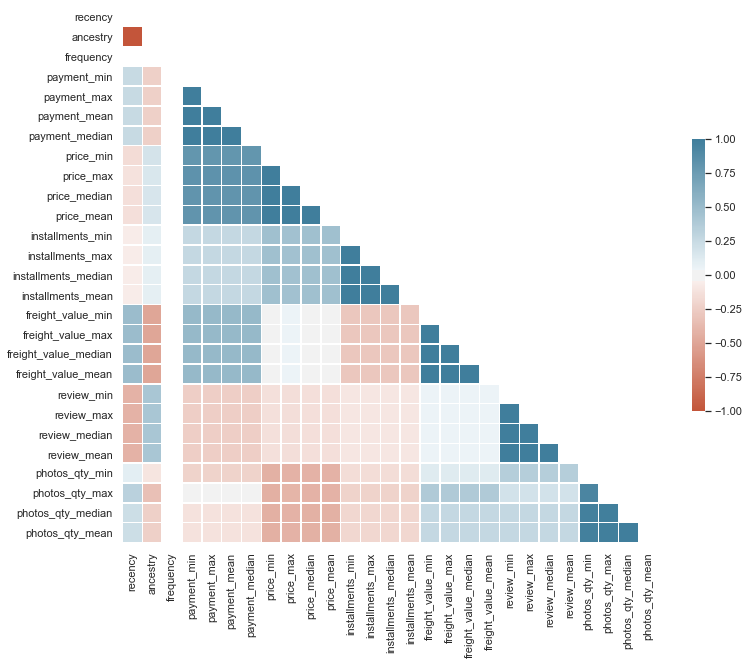

In [141]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_1_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [142]:
# Suppression des features trop corrélées

df_1_months = df_1_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_1_months.shape

(11, 8)

<AxesSubplot:>

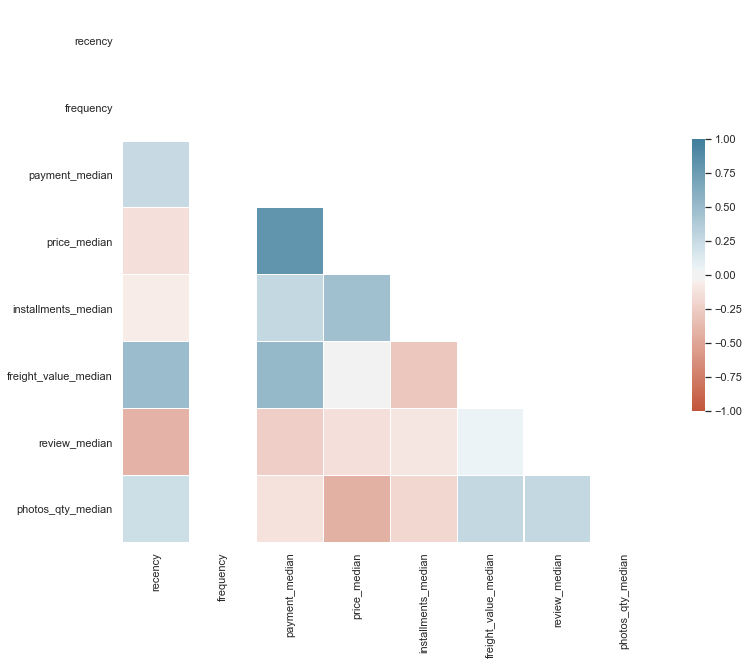

In [143]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_1_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [144]:
df_1_months.shape

(11, 8)

# 2 mois 

## Features basées sur la récence

In [145]:
# 2 mois
df_2_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2016-11-04', :]
df_2_months.shape

(380, 18)

In [146]:
df_2_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [147]:
df_2_months['order_purchase_timestamp'].max()

Timestamp('2016-10-10 18:09:39')

In [148]:
# recency 

most_recent_purchase_date_2_months = df_2_months['order_purchase_timestamp'].max()
most_recent_purchase_date_2_months

Timestamp('2016-10-10 18:09:39')

In [149]:
df_recency_2_months = df_2_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_2_months.name = 'recency'
df_recency_2_months = pd.DataFrame(df_recency_2_months)
df_recency_2_months

,recency
customer_unique_id,
0032c76b20340da25249092a268ce66c,696
01f156677184504063bd19739f924af1,692
0313291a6f4f16df04dcf819d88c38ef,693
0636d30c77f0f9cfad81f1c9b58c791f,695
0659f2d6cabae94afd4d009c6d0e07dc,693
...,...
fdaa290acb9eeacb66fa7f979baa6803,695
ff39ae410be7f9b3a2457c546c6f67de,697
ff68ad2883e793597f1c343dd6505f5d,696


In [150]:
# ancestry
most_old_purchase_date_2_months = df_2_months['order_purchase_timestamp'].min()
most_old_purchase_date_2_months

Timestamp('2016-09-04 21:15:19')

In [151]:
df_ancestry_2_months = df_2_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_2_months.name = 'ancestry'
df_ancestry_2_months = pd.DataFrame(df_ancestry_2_months)
df_ancestry_2_months

,ancestry
customer_unique_id,
0032c76b20340da25249092a268ce66c,31
01f156677184504063bd19739f924af1,35
0313291a6f4f16df04dcf819d88c38ef,34
0636d30c77f0f9cfad81f1c9b58c791f,33
0659f2d6cabae94afd4d009c6d0e07dc,34
...,...
fdaa290acb9eeacb66fa7f979baa6803,33
ff39ae410be7f9b3a2457c546c6f67de,30
ff68ad2883e793597f1c343dd6505f5d,31


# Features de fréquence

In [152]:
# Nombre de commande passée par chaque client unique

df_frequency_2_months = df_2_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_2_months.name = 'frequency'
df_frequency_2_months = pd.DataFrame(df_frequency_2_months)
df_frequency_2_months

,frequency
customer_unique_id,
7a176e5d88c7acb6000a055e008c055d,2
f7b62c75467e8ce080b201667cbbc274,2
0ecf7f65b5ff3b9e61b637e59f495e0a,2
b139fbdcd53f8036eb05d3023fc97580,1
b10f780a5e22a8c7fbce07bb3da6eeff,1
...,...
4bb9eff279b892251d672d74a4272434,1
4b753f7e58c2f8129715691ba3957fda,1
4a6959f9a4aca95bb3733032d0a50c9e,1


# Features monétaires

In [153]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_2_months = df_2_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_2_months.columns = df_monetary_value_2_months.columns.get_level_values(1)
df_monetary_value_2_months.columns = ['payment_' + col for col in df_monetary_value_2_months.columns]
df_monetary_value_2_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,144.94,144.94,144.940,144.940
01f156677184504063bd19739f924af1,784.80,784.80,784.800,784.800
0313291a6f4f16df04dcf819d88c38ef,112.78,112.78,112.780,112.780
0636d30c77f0f9cfad81f1c9b58c791f,971.96,971.96,971.960,971.960
0659f2d6cabae94afd4d009c6d0e07dc,459.14,459.14,459.140,459.140
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1423.55,1423.55,1423.550,1423.550
ff39ae410be7f9b3a2457c546c6f67de,47.92,50.63,49.275,49.275
ff68ad2883e793597f1c343dd6505f5d,534.98,534.98,534.980,534.980


In [154]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_2_months = df_2_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_2_months.columns = df_price_2_months.columns.get_level_values(1)
df_price_2_months.columns = ['price_' + col for col in df_price_2_months.columns]
df_price_2_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,128.90,128.90,128.90,128.90
01f156677184504063bd19739f924af1,739.98,739.98,739.98,739.98
0313291a6f4f16df04dcf819d88c38ef,95.00,95.00,95.00,95.00
0636d30c77f0f9cfad81f1c9b58c791f,949.99,949.99,949.99,949.99
0659f2d6cabae94afd4d009c6d0e07dc,195.00,195.00,195.00,195.00
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1399.00,1399.00,1399.00,1399.00
ff39ae410be7f9b3a2457c546c6f67de,79.90,79.90,79.90,79.90
ff68ad2883e793597f1c343dd6505f5d,249.90,249.90,249.90,249.90


In [155]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_2_months = df_2_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_2_months.columns = df_installments_2_months.columns.get_level_values(1)
df_installments_2_months.columns = ['installments_' + col for col in df_installments_2_months.columns]
df_installments_2_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1,1,1,1.0
01f156677184504063bd19739f924af1,10,10,10,10.0
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1.0
0636d30c77f0f9cfad81f1c9b58c791f,10,10,10,10.0
0659f2d6cabae94afd4d009c6d0e07dc,4,4,4,4.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,10,10,10,10.0
ff39ae410be7f9b3a2457c546c6f67de,1,1,1,1.0
ff68ad2883e793597f1c343dd6505f5d,8,8,8,8.0


In [156]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_2_months = df_2_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_2_months.columns = df_freight_value_2_months.columns.get_level_values(1)
df_freight_value_2_months.columns = ['freight_value_' + col for col in df_freight_value_2_months.columns]
df_freight_value_2_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,16.04,16.04,16.04,16.04
01f156677184504063bd19739f924af1,44.82,44.82,44.82,44.82
0313291a6f4f16df04dcf819d88c38ef,17.78,17.78,17.78,17.78
0636d30c77f0f9cfad81f1c9b58c791f,21.97,21.97,21.97,21.97
0659f2d6cabae94afd4d009c6d0e07dc,34.57,34.57,34.57,34.57
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,24.55,24.55,24.55,24.55
ff39ae410be7f9b3a2457c546c6f67de,18.65,18.65,18.65,18.65
ff68ad2883e793597f1c343dd6505f5d,17.59,17.59,17.59,17.59


# Autres features axé sur les clients

In [157]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_2_months = df_2_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_2_months.columns = df_review_2_months.columns.get_level_values(1)
df_review_2_months.columns = ['review_' + col for col in df_review_2_months.columns]
df_review_2_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,4,4,4,4
01f156677184504063bd19739f924af1,5,5,5,5
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1
0636d30c77f0f9cfad81f1c9b58c791f,4,4,4,4
0659f2d6cabae94afd4d009c6d0e07dc,1,1,1,1
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,5,5,5,5
ff39ae410be7f9b3a2457c546c6f67de,3,3,3,3
ff68ad2883e793597f1c343dd6505f5d,5,5,5,5


In [158]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_2_months = df_2_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_2_months.columns = df_photos_2_months.columns.get_level_values(1)
df_photos_2_months.columns = ['photos_qty_' + col for col in df_photos_2_months.columns]
df_photos_2_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1.0,1.0,1.0,1.0
01f156677184504063bd19739f924af1,2.0,2.0,2.0,2.0
0313291a6f4f16df04dcf819d88c38ef,1.0,1.0,1.0,1.0
0636d30c77f0f9cfad81f1c9b58c791f,2.0,2.0,2.0,2.0
0659f2d6cabae94afd4d009c6d0e07dc,1.0,1.0,1.0,1.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,3.0,3.0,3.0,3.0
ff39ae410be7f9b3a2457c546c6f67de,4.0,4.0,4.0,4.0
ff68ad2883e793597f1c343dd6505f5d,1.0,1.0,1.0,1.0


In [159]:
# Nombre de régions différentes par client

df_cust_state_2_months = df_2_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_2_months

,customer_state
customer_unique_id,
0032c76b20340da25249092a268ce66c,1
01f156677184504063bd19739f924af1,1
0313291a6f4f16df04dcf819d88c38ef,1
0636d30c77f0f9cfad81f1c9b58c791f,1
0659f2d6cabae94afd4d009c6d0e07dc,2
...,...
fdaa290acb9eeacb66fa7f979baa6803,1
ff39ae410be7f9b3a2457c546c6f67de,2
ff68ad2883e793597f1c343dd6505f5d,2


In [160]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_2_months = df_cust_state_2_months.loc[df_cust_state_2_months['customer_state']>1]
df_custom_multi_state_2_months

,customer_state
customer_unique_id,
0659f2d6cabae94afd4d009c6d0e07dc,2
0a02ba4243b1b0e048a3841d5758d113,2
0ecf7f65b5ff3b9e61b637e59f495e0a,8
1881f0742867dc75d6e0bcc24f866710,2
221234182f828fb9f2a4ba9c89874ede,4
2e15add79c76241beffe812a24ad3a31,2
2f96790fba243100730c8d1185dd2f25,2
30fceee7cb0dbe6926f2b1128f2b3648,2
4a6959f9a4aca95bb3733032d0a50c9e,2


In [161]:
# Sélectionner la première région pour chaque client dans le dataframe pour du One Hot Encoding

df_custom_single_state_2_months = df_2_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_2_months 

,customer_unique_id,customer_state
330,1c5aefec1a2943edd15e52f9e2900e41,MG
333,4b753f7e58c2f8129715691ba3957fda,SP
718,48eb05fb37e33f3079495d0145ef2711,ES
805,a36dfd7f887f03e4818a77b11784236e,SP
811,c8befcc96d8aeb7181c618aa56d9d624,SP
...,...,...
113557,e3626c985901df173504f3d285ac823f,RJ
114899,33faaac58c27088e3a8a8afd6058a6de,SP
114914,be8375783b7439dd7ef30b89fb46188b,RJ
115102,07d5b1f9bdd053347f0213187b343ac9,SP


# AGREGATION DES FEATURES

In [162]:
df_2_months = pd.merge(df_recency_2_months,df_ancestry_2_months,  on='customer_unique_id')
df_2_months.shape

(300, 2)

In [163]:
df_2_months = pd.merge(df_2_months, df_frequency_2_months,  on='customer_unique_id')

In [164]:
df_2_months = pd.merge(df_2_months, df_monetary_value_2_months, on='customer_unique_id')

In [165]:
df_2_months = pd.merge(df_2_months, df_price_2_months,  on='customer_unique_id')

In [166]:
df_2_months = pd.merge(df_2_months, df_installments_2_months,  on='customer_unique_id')

In [167]:
df_2_months = pd.merge(df_2_months, df_freight_value_2_months,  on='customer_unique_id')

In [168]:
df_2_months = pd.merge(df_2_months, df_review_2_months,  on='customer_unique_id')

In [169]:
df_2_months = pd.merge(df_2_months, df_photos_2_months,  on='customer_unique_id')
df_2_months.shape

(300, 27)

<AxesSubplot:>

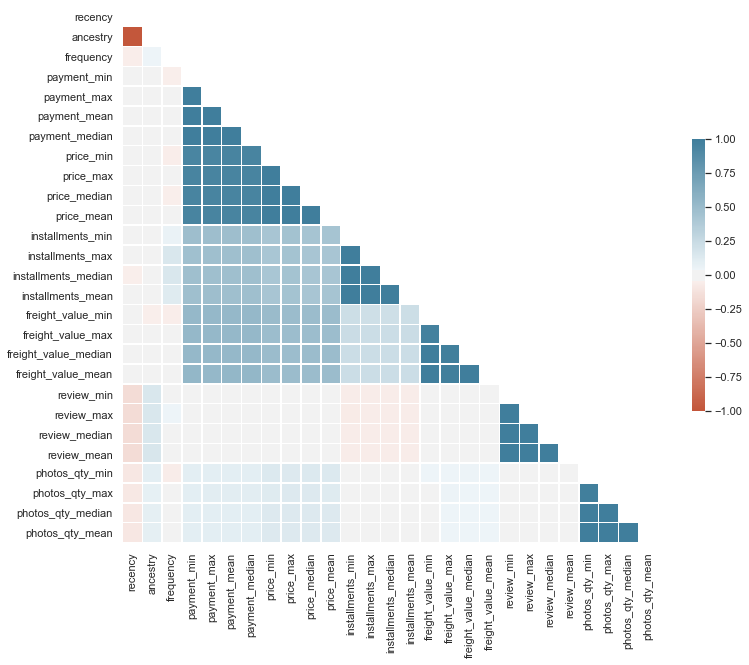

In [170]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_2_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [171]:
# Suppression des features trop corrélées
df_2_months = df_2_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_2_months.shape

(300, 8)

<AxesSubplot:>

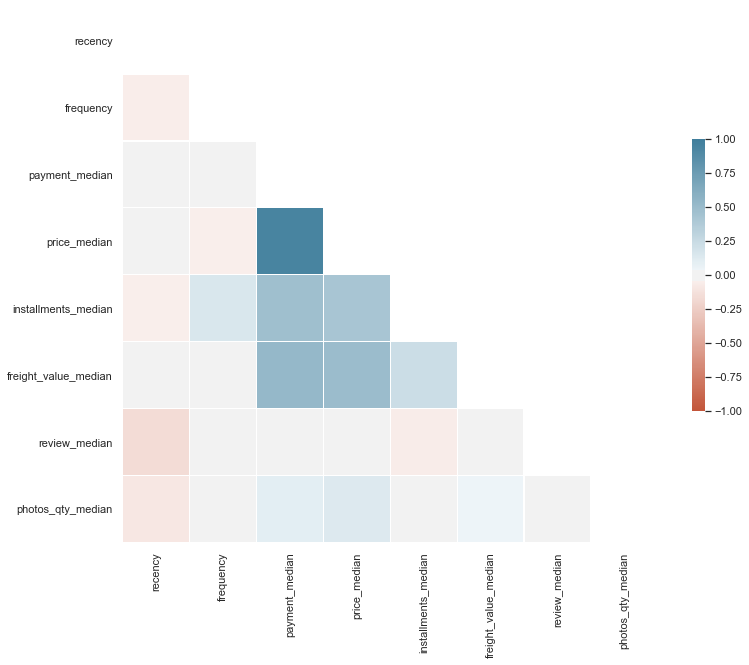

In [172]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_2_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [173]:
df_2_months.shape

(300, 8)

# 3 mois 

# Features basées sur la récence

In [174]:
# 3 mois
df_3_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2016-12-04', :]
df_3_months.shape

(380, 18)

In [175]:
df_3_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [176]:
df_3_months['order_purchase_timestamp'].max()

Timestamp('2016-10-10 18:09:39')

In [177]:
# Recency 

most_recent_purchase_date_3_months = df_3_months['order_purchase_timestamp'].max()
most_recent_purchase_date_3_months

Timestamp('2016-10-10 18:09:39')

In [178]:
df_recency_3_months = df_3_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_3_months.name = 'recency'
df_recency_3_months = pd.DataFrame(df_recency_3_months)
df_recency_3_months

,recency
customer_unique_id,
0032c76b20340da25249092a268ce66c,696
01f156677184504063bd19739f924af1,692
0313291a6f4f16df04dcf819d88c38ef,693
0636d30c77f0f9cfad81f1c9b58c791f,695
0659f2d6cabae94afd4d009c6d0e07dc,693
...,...
fdaa290acb9eeacb66fa7f979baa6803,695
ff39ae410be7f9b3a2457c546c6f67de,697
ff68ad2883e793597f1c343dd6505f5d,696


In [179]:
# Ancestry

most_old_purchase_date_3_months = df_3_months['order_purchase_timestamp'].min()
most_old_purchase_date_3_months

Timestamp('2016-09-04 21:15:19')

In [180]:
df_ancestry_3_months = df_3_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_3_months.name = 'ancestry'
df_ancestry_3_months = pd.DataFrame(df_ancestry_3_months)
df_ancestry_3_months

,ancestry
customer_unique_id,
0032c76b20340da25249092a268ce66c,31
01f156677184504063bd19739f924af1,35
0313291a6f4f16df04dcf819d88c38ef,34
0636d30c77f0f9cfad81f1c9b58c791f,33
0659f2d6cabae94afd4d009c6d0e07dc,34
...,...
fdaa290acb9eeacb66fa7f979baa6803,33
ff39ae410be7f9b3a2457c546c6f67de,30
ff68ad2883e793597f1c343dd6505f5d,31


# Features de fréquence

In [181]:
# Nombre de commande passée par chaque client unique

df_frequency_3_months = df_3_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_3_months.name = 'frequency'
df_frequency_3_months = pd.DataFrame(df_frequency_3_months)
df_frequency_3_months

,frequency
customer_unique_id,
7a176e5d88c7acb6000a055e008c055d,2
f7b62c75467e8ce080b201667cbbc274,2
0ecf7f65b5ff3b9e61b637e59f495e0a,2
b139fbdcd53f8036eb05d3023fc97580,1
b10f780a5e22a8c7fbce07bb3da6eeff,1
...,...
4bb9eff279b892251d672d74a4272434,1
4b753f7e58c2f8129715691ba3957fda,1
4a6959f9a4aca95bb3733032d0a50c9e,1


# Features monétaires

In [182]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_3_months = df_3_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_3_months.columns = df_monetary_value_3_months.columns.get_level_values(1)
df_monetary_value_3_months.columns = ['payment_' + col for col in df_monetary_value_3_months.columns]
df_monetary_value_3_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,144.94,144.94,144.940,144.940
01f156677184504063bd19739f924af1,784.80,784.80,784.800,784.800
0313291a6f4f16df04dcf819d88c38ef,112.78,112.78,112.780,112.780
0636d30c77f0f9cfad81f1c9b58c791f,971.96,971.96,971.960,971.960
0659f2d6cabae94afd4d009c6d0e07dc,459.14,459.14,459.140,459.140
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1423.55,1423.55,1423.550,1423.550
ff39ae410be7f9b3a2457c546c6f67de,47.92,50.63,49.275,49.275
ff68ad2883e793597f1c343dd6505f5d,534.98,534.98,534.980,534.980


In [183]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_3_months = df_3_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_3_months.columns = df_price_3_months.columns.get_level_values(1)
df_price_3_months.columns = ['price_' + col for col in df_price_3_months.columns]
df_price_3_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,128.90,128.90,128.90,128.90
01f156677184504063bd19739f924af1,739.98,739.98,739.98,739.98
0313291a6f4f16df04dcf819d88c38ef,95.00,95.00,95.00,95.00
0636d30c77f0f9cfad81f1c9b58c791f,949.99,949.99,949.99,949.99
0659f2d6cabae94afd4d009c6d0e07dc,195.00,195.00,195.00,195.00
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1399.00,1399.00,1399.00,1399.00
ff39ae410be7f9b3a2457c546c6f67de,79.90,79.90,79.90,79.90
ff68ad2883e793597f1c343dd6505f5d,249.90,249.90,249.90,249.90


In [184]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_3_months = df_3_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_3_months.columns = df_installments_3_months.columns.get_level_values(1)
df_installments_3_months.columns = ['installments_' + col for col in df_installments_3_months.columns]
df_installments_3_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1,1,1,1.0
01f156677184504063bd19739f924af1,10,10,10,10.0
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1.0
0636d30c77f0f9cfad81f1c9b58c791f,10,10,10,10.0
0659f2d6cabae94afd4d009c6d0e07dc,4,4,4,4.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,10,10,10,10.0
ff39ae410be7f9b3a2457c546c6f67de,1,1,1,1.0
ff68ad2883e793597f1c343dd6505f5d,8,8,8,8.0


In [185]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_3_months = df_3_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_3_months.columns = df_freight_value_3_months.columns.get_level_values(1)
df_freight_value_3_months.columns = ['freight_value_' + col for col in df_freight_value_3_months.columns]
df_freight_value_3_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,16.04,16.04,16.04,16.04
01f156677184504063bd19739f924af1,44.82,44.82,44.82,44.82
0313291a6f4f16df04dcf819d88c38ef,17.78,17.78,17.78,17.78
0636d30c77f0f9cfad81f1c9b58c791f,21.97,21.97,21.97,21.97
0659f2d6cabae94afd4d009c6d0e07dc,34.57,34.57,34.57,34.57
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,24.55,24.55,24.55,24.55
ff39ae410be7f9b3a2457c546c6f67de,18.65,18.65,18.65,18.65
ff68ad2883e793597f1c343dd6505f5d,17.59,17.59,17.59,17.59


# Autres features axé sur les clients

In [186]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_3_months = df_3_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_3_months.columns = df_review_3_months.columns.get_level_values(1)
df_review_3_months.columns = ['review_' + col for col in df_review_3_months.columns]
df_review_3_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,4,4,4,4
01f156677184504063bd19739f924af1,5,5,5,5
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1
0636d30c77f0f9cfad81f1c9b58c791f,4,4,4,4
0659f2d6cabae94afd4d009c6d0e07dc,1,1,1,1
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,5,5,5,5
ff39ae410be7f9b3a2457c546c6f67de,3,3,3,3
ff68ad2883e793597f1c343dd6505f5d,5,5,5,5


In [187]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_3_months = df_3_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_3_months.columns = df_photos_3_months.columns.get_level_values(1)
df_photos_3_months.columns = ['photos_qty_' + col for col in df_photos_3_months.columns]
df_photos_3_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1.0,1.0,1.0,1.0
01f156677184504063bd19739f924af1,2.0,2.0,2.0,2.0
0313291a6f4f16df04dcf819d88c38ef,1.0,1.0,1.0,1.0
0636d30c77f0f9cfad81f1c9b58c791f,2.0,2.0,2.0,2.0
0659f2d6cabae94afd4d009c6d0e07dc,1.0,1.0,1.0,1.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,3.0,3.0,3.0,3.0
ff39ae410be7f9b3a2457c546c6f67de,4.0,4.0,4.0,4.0
ff68ad2883e793597f1c343dd6505f5d,1.0,1.0,1.0,1.0


In [188]:
# Nombre de régions différentes par client

df_cust_state_3_months = df_3_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_3_months

,customer_state
customer_unique_id,
0032c76b20340da25249092a268ce66c,1
01f156677184504063bd19739f924af1,1
0313291a6f4f16df04dcf819d88c38ef,1
0636d30c77f0f9cfad81f1c9b58c791f,1
0659f2d6cabae94afd4d009c6d0e07dc,2
...,...
fdaa290acb9eeacb66fa7f979baa6803,1
ff39ae410be7f9b3a2457c546c6f67de,2
ff68ad2883e793597f1c343dd6505f5d,2


In [189]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_3_months = df_cust_state_3_months.loc[df_cust_state_3_months['customer_state']>1]
df_custom_multi_state_3_months

,customer_state
customer_unique_id,
0659f2d6cabae94afd4d009c6d0e07dc,2
0a02ba4243b1b0e048a3841d5758d113,2
0ecf7f65b5ff3b9e61b637e59f495e0a,8
1881f0742867dc75d6e0bcc24f866710,2
221234182f828fb9f2a4ba9c89874ede,4
2e15add79c76241beffe812a24ad3a31,2
2f96790fba243100730c8d1185dd2f25,2
30fceee7cb0dbe6926f2b1128f2b3648,2
4a6959f9a4aca95bb3733032d0a50c9e,2


In [190]:
# Sélectionner la première région pour chaque client dans le dataframe pour du One Hot Encoding

df_custom_single_state_3_months = df_3_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_3_months 

,customer_unique_id,customer_state
330,1c5aefec1a2943edd15e52f9e2900e41,MG
333,4b753f7e58c2f8129715691ba3957fda,SP
718,48eb05fb37e33f3079495d0145ef2711,ES
805,a36dfd7f887f03e4818a77b11784236e,SP
811,c8befcc96d8aeb7181c618aa56d9d624,SP
...,...,...
113557,e3626c985901df173504f3d285ac823f,RJ
114899,33faaac58c27088e3a8a8afd6058a6de,SP
114914,be8375783b7439dd7ef30b89fb46188b,RJ
115102,07d5b1f9bdd053347f0213187b343ac9,SP


# AGREGATION DES FEATURES

In [191]:
df_3_months.shape 

(380, 18)

In [192]:
df_3_months = pd.merge(df_recency_3_months,df_ancestry_3_months,  on='customer_unique_id')
df_3_months.shape

(300, 2)

In [193]:
df_3_months = pd.merge(df_3_months, df_frequency_3_months,  on='customer_unique_id')

In [194]:
df_3_months = pd.merge(df_3_months, df_monetary_value_3_months, on='customer_unique_id')

In [195]:
df_3_months = pd.merge(df_3_months, df_price_3_months,  on='customer_unique_id')

In [196]:
df_3_months = pd.merge(df_3_months, df_installments_3_months,  on='customer_unique_id')

In [197]:
df_3_months = pd.merge(df_3_months, df_freight_value_3_months,  on='customer_unique_id')

In [198]:
df_3_months = pd.merge(df_3_months, df_review_3_months,  on='customer_unique_id')

In [199]:
df_3_months = pd.merge(df_3_months, df_photos_3_months,  on='customer_unique_id')
df_3_months.shape

(300, 27)

<AxesSubplot:>

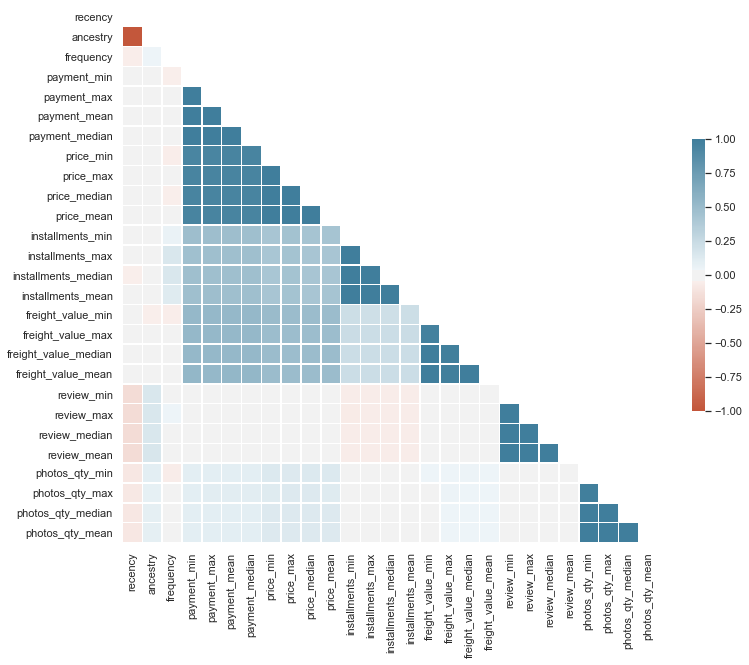

In [200]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_3_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [201]:
# Suppression des features trop corrélées
df_3_months = df_3_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_3_months.shape

(300, 8)

<AxesSubplot:>

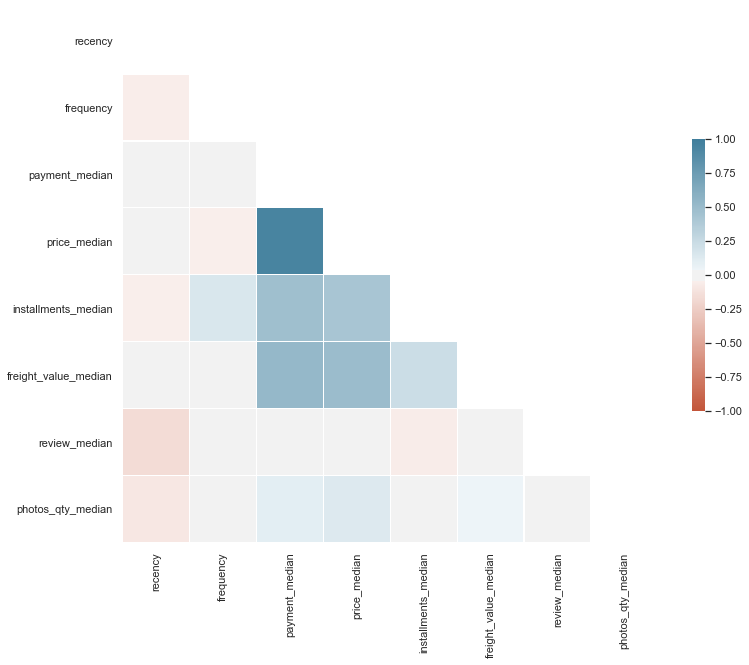

In [202]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_3_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [203]:
df_3_months.shape

(300, 8)

# 4 mois

## Features basées sur la récence

In [204]:
# 4 mois
df_4_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2017-01-04', :]
df_4_months.shape

(381, 18)

In [205]:
df_4_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [206]:
df_4_months['order_purchase_timestamp'].max()

Timestamp('2016-12-23 23:16:47')

In [207]:
# recency 

most_recent_purchase_date_4_months = df_4_months['order_purchase_timestamp'].max()
most_recent_purchase_date_4_months

Timestamp('2016-12-23 23:16:47')

In [208]:
df_recency_4_months = df_4_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_4_months.name = 'recency'
df_recency_4_months = pd.DataFrame(df_recency_4_months)
df_recency_4_months

,recency
customer_unique_id,
0032c76b20340da25249092a268ce66c,696
01f156677184504063bd19739f924af1,692
0313291a6f4f16df04dcf819d88c38ef,693
0636d30c77f0f9cfad81f1c9b58c791f,695
0659f2d6cabae94afd4d009c6d0e07dc,693
...,...
fdaa290acb9eeacb66fa7f979baa6803,695
ff39ae410be7f9b3a2457c546c6f67de,697
ff68ad2883e793597f1c343dd6505f5d,696


In [209]:
# ancestry
most_old_purchase_date_4_months = df_4_months['order_purchase_timestamp'].min()
most_old_purchase_date_4_months

Timestamp('2016-09-04 21:15:19')

In [210]:
df_ancestry_4_months = df_4_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_4_months.name = 'ancestry'
df_ancestry_4_months = pd.DataFrame(df_ancestry_4_months)
df_ancestry_4_months

,ancestry
customer_unique_id,
0032c76b20340da25249092a268ce66c,31
01f156677184504063bd19739f924af1,35
0313291a6f4f16df04dcf819d88c38ef,34
0636d30c77f0f9cfad81f1c9b58c791f,33
0659f2d6cabae94afd4d009c6d0e07dc,34
...,...
fdaa290acb9eeacb66fa7f979baa6803,33
ff39ae410be7f9b3a2457c546c6f67de,30
ff68ad2883e793597f1c343dd6505f5d,31


# Features de fréquence

In [211]:
# Nombre de commande passée par chaque client unique

df_frequency_4_months = df_4_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_4_months.name = 'frequency'
df_frequency_4_months = pd.DataFrame(df_frequency_4_months)
df_frequency_4_months

,frequency
customer_unique_id,
7a176e5d88c7acb6000a055e008c055d,2
0ecf7f65b5ff3b9e61b637e59f495e0a,2
f7b62c75467e8ce080b201667cbbc274,2
acf5cef98a4798f470a2bb70a330ac07,1
b18b6d40c3c5510727e0f22b568d3e1f,1
...,...
4bb9eff279b892251d672d74a4272434,1
4b753f7e58c2f8129715691ba3957fda,1
4a6959f9a4aca95bb3733032d0a50c9e,1


# Features monétaires

In [212]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_4_months = df_4_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_4_months.columns = df_monetary_value_4_months.columns.get_level_values(1)
df_monetary_value_4_months.columns = ['payment_' + col for col in df_monetary_value_4_months.columns]
df_monetary_value_4_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,144.94,144.94,144.940,144.940
01f156677184504063bd19739f924af1,784.80,784.80,784.800,784.800
0313291a6f4f16df04dcf819d88c38ef,112.78,112.78,112.780,112.780
0636d30c77f0f9cfad81f1c9b58c791f,971.96,971.96,971.960,971.960
0659f2d6cabae94afd4d009c6d0e07dc,459.14,459.14,459.140,459.140
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1423.55,1423.55,1423.550,1423.550
ff39ae410be7f9b3a2457c546c6f67de,47.92,50.63,49.275,49.275
ff68ad2883e793597f1c343dd6505f5d,534.98,534.98,534.980,534.980


In [213]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_4_months = df_4_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_4_months.columns = df_price_4_months.columns.get_level_values(1)
df_price_4_months.columns = ['price_' + col for col in df_price_4_months.columns]
df_price_4_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,128.90,128.90,128.90,128.90
01f156677184504063bd19739f924af1,739.98,739.98,739.98,739.98
0313291a6f4f16df04dcf819d88c38ef,95.00,95.00,95.00,95.00
0636d30c77f0f9cfad81f1c9b58c791f,949.99,949.99,949.99,949.99
0659f2d6cabae94afd4d009c6d0e07dc,195.00,195.00,195.00,195.00
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,1399.00,1399.00,1399.00,1399.00
ff39ae410be7f9b3a2457c546c6f67de,79.90,79.90,79.90,79.90
ff68ad2883e793597f1c343dd6505f5d,249.90,249.90,249.90,249.90


In [214]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_4_months = df_4_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_4_months.columns = df_installments_4_months.columns.get_level_values(1)
df_installments_4_months.columns = ['installments_' + col for col in df_installments_4_months.columns]
df_installments_4_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1,1,1,1.0
01f156677184504063bd19739f924af1,10,10,10,10.0
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1.0
0636d30c77f0f9cfad81f1c9b58c791f,10,10,10,10.0
0659f2d6cabae94afd4d009c6d0e07dc,4,4,4,4.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,10,10,10,10.0
ff39ae410be7f9b3a2457c546c6f67de,1,1,1,1.0
ff68ad2883e793597f1c343dd6505f5d,8,8,8,8.0


In [215]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_4_months = df_4_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_4_months.columns = df_freight_value_4_months.columns.get_level_values(1)
df_freight_value_4_months.columns = ['freight_value_' + col for col in df_freight_value_4_months.columns]
df_freight_value_4_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,16.04,16.04,16.04,16.04
01f156677184504063bd19739f924af1,44.82,44.82,44.82,44.82
0313291a6f4f16df04dcf819d88c38ef,17.78,17.78,17.78,17.78
0636d30c77f0f9cfad81f1c9b58c791f,21.97,21.97,21.97,21.97
0659f2d6cabae94afd4d009c6d0e07dc,34.57,34.57,34.57,34.57
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,24.55,24.55,24.55,24.55
ff39ae410be7f9b3a2457c546c6f67de,18.65,18.65,18.65,18.65
ff68ad2883e793597f1c343dd6505f5d,17.59,17.59,17.59,17.59


# Autres features axé sur les clients

In [216]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_4_months = df_4_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_4_months.columns = df_review_4_months.columns.get_level_values(1)
df_review_4_months.columns = ['review_' + col for col in df_review_4_months.columns]
df_review_4_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,4,4,4,4
01f156677184504063bd19739f924af1,5,5,5,5
0313291a6f4f16df04dcf819d88c38ef,1,1,1,1
0636d30c77f0f9cfad81f1c9b58c791f,4,4,4,4
0659f2d6cabae94afd4d009c6d0e07dc,1,1,1,1
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,5,5,5,5
ff39ae410be7f9b3a2457c546c6f67de,3,3,3,3
ff68ad2883e793597f1c343dd6505f5d,5,5,5,5


In [217]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_4_months = df_4_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_4_months.columns = df_photos_4_months.columns.get_level_values(1)
df_photos_4_months.columns = ['photos_qty_' + col for col in df_photos_4_months.columns]
df_photos_4_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
0032c76b20340da25249092a268ce66c,1.0,1.0,1.0,1.0
01f156677184504063bd19739f924af1,2.0,2.0,2.0,2.0
0313291a6f4f16df04dcf819d88c38ef,1.0,1.0,1.0,1.0
0636d30c77f0f9cfad81f1c9b58c791f,2.0,2.0,2.0,2.0
0659f2d6cabae94afd4d009c6d0e07dc,1.0,1.0,1.0,1.0
...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,3.0,3.0,3.0,3.0
ff39ae410be7f9b3a2457c546c6f67de,4.0,4.0,4.0,4.0
ff68ad2883e793597f1c343dd6505f5d,1.0,1.0,1.0,1.0


In [218]:
# Nombre de régions  différentes par client

df_cust_state_4_months = df_4_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_4_months

,customer_state
customer_unique_id,
0032c76b20340da25249092a268ce66c,1
01f156677184504063bd19739f924af1,1
0313291a6f4f16df04dcf819d88c38ef,1
0636d30c77f0f9cfad81f1c9b58c791f,1
0659f2d6cabae94afd4d009c6d0e07dc,2
...,...
fdaa290acb9eeacb66fa7f979baa6803,1
ff39ae410be7f9b3a2457c546c6f67de,2
ff68ad2883e793597f1c343dd6505f5d,2


In [219]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_4_months = df_cust_state_4_months.loc[df_cust_state_4_months['customer_state']>1]
df_custom_multi_state_4_months

,customer_state
customer_unique_id,
0659f2d6cabae94afd4d009c6d0e07dc,2
0a02ba4243b1b0e048a3841d5758d113,2
0ecf7f65b5ff3b9e61b637e59f495e0a,8
1881f0742867dc75d6e0bcc24f866710,2
221234182f828fb9f2a4ba9c89874ede,4
2e15add79c76241beffe812a24ad3a31,2
2f96790fba243100730c8d1185dd2f25,2
30fceee7cb0dbe6926f2b1128f2b3648,2
4a6959f9a4aca95bb3733032d0a50c9e,2


In [220]:
# Sélectionner la première région pour chaquee client dans le dataframe pour du One Hot Encoding

df_custom_single_state_4_months = df_4_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_4_months

,customer_unique_id,customer_state
330,1c5aefec1a2943edd15e52f9e2900e41,MG
333,4b753f7e58c2f8129715691ba3957fda,SP
718,48eb05fb37e33f3079495d0145ef2711,ES
805,a36dfd7f887f03e4818a77b11784236e,SP
811,c8befcc96d8aeb7181c618aa56d9d624,SP
...,...,...
113557,e3626c985901df173504f3d285ac823f,RJ
114899,33faaac58c27088e3a8a8afd6058a6de,SP
114914,be8375783b7439dd7ef30b89fb46188b,RJ
115102,07d5b1f9bdd053347f0213187b343ac9,SP


# AGREGATION DES FEATURES

In [221]:
df_4_months = pd.merge(df_recency_4_months,df_ancestry_4_months,  on='customer_unique_id')
df_4_months.shape

(301, 2)

In [222]:
df_4_months = pd.merge(df_4_months, df_frequency_4_months,  on='customer_unique_id')

In [223]:
df_4_months = pd.merge(df_4_months, df_monetary_value_4_months, on='customer_unique_id')

In [224]:
df_4_months = pd.merge(df_4_months, df_price_4_months,  on='customer_unique_id')

In [225]:
df_4_months = pd.merge(df_4_months, df_installments_4_months,  on='customer_unique_id')

In [226]:
df_4_months = pd.merge(df_4_months, df_freight_value_4_months,  on='customer_unique_id')

In [227]:
df_4_months = pd.merge(df_4_months, df_review_4_months,  on='customer_unique_id')

In [228]:
df_4_months = pd.merge(df_4_months, df_photos_4_months,  on='customer_unique_id')
df_4_months.shape

(301, 27)

In [229]:
df_4_months

,recency,ancestry,frequency,payment_min,payment_max,payment_mean,payment_median,price_min,price_max,price_median,price_mean,installments_min,installments_max,installments_median,installments_mean,freight_value_min,freight_value_max,freight_value_median,freight_value_mean,review_min,review_max,review_median,review_mean,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0032c76b20340da25249092a268ce66c,696,31,1,144.94,144.94,144.940,144.940,128.90,128.90,128.90,128.90,1,1,1,1.0,16.04,16.04,16.04,16.04,4,4,4,4,1.0,1.0,1.0,1.0
01f156677184504063bd19739f924af1,692,35,1,784.80,784.80,784.800,784.800,739.98,739.98,739.98,739.98,10,10,10,10.0,44.82,44.82,44.82,44.82,5,5,5,5,2.0,2.0,2.0,2.0
0313291a6f4f16df04dcf819d88c38ef,693,34,1,112.78,112.78,112.780,112.780,95.00,95.00,95.00,95.00,1,1,1,1.0,17.78,17.78,17.78,17.78,1,1,1,1,1.0,1.0,1.0,1.0
0636d30c77f0f9cfad81f1c9b58c791f,695,33,1,971.96,971.96,971.960,971.960,949.99,949.99,949.99,949.99,10,10,10,10.0,21.97,21.97,21.97,21.97,4,4,4,4,2.0,2.0,2.0,2.0
0659f2d6cabae94afd4d009c6d0e07dc,693,34,1,459.14,459.14,459.140,459.140,195.00,195.00,195.00,195.00,4,4,4,4.0,34.57,34.57,34.57,34.57,1,1,1,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdaa290acb9eeacb66fa7f979baa6803,695,33,1,1423.55,1423.55,1423.550,1423.550,1399.00,1399.00,1399.00,1399.00,10,10,10,10.0,24.55,24.55,24.55,24.55,5,5,5,5,3.0,3.0,3.0,3.0
ff39ae410be7f9b3a2457c546c6f67de,697,30,1,47.92,50.63,49.275,49.275,79.90,79.90,79.90,79.90,1,1,1,1.0,18.65,18.65,18.65,18.65,3,3,3,3,4.0,4.0,4.0,4.0
ff68ad2883e793597f1c343dd6505f5d,696,31,1,534.98,534.98,534.980,534.980,249.90,249.90,249.90,249.90,8,8,8,8.0,17.59,17.59,17.59,17.59,5,5,5,5,1.0,1.0,1.0,1.0


<AxesSubplot:>

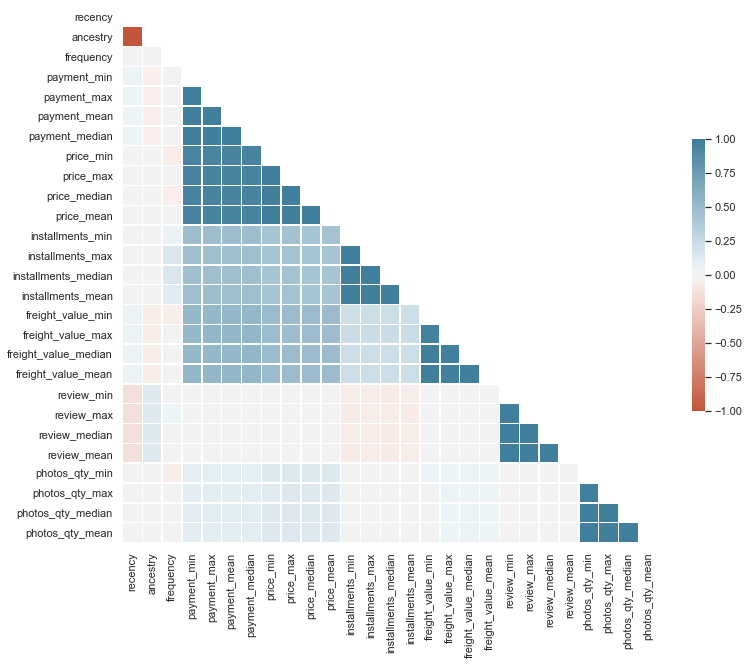

In [230]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_4_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [231]:
# Suppression des features trop corrélées

df_4_months = df_4_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_4_months.shape

(301, 8)

<AxesSubplot:>

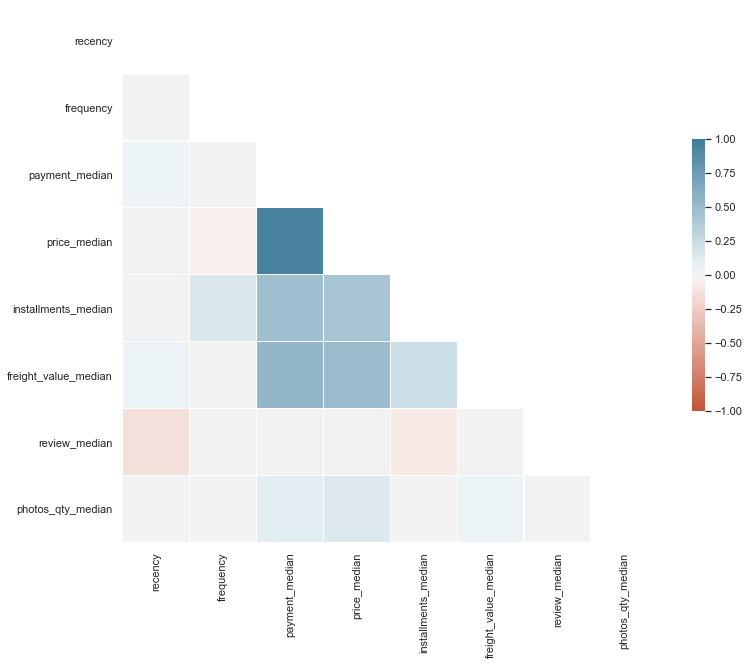

In [232]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_4_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 5 mois

## Features basées sur la récence

In [233]:
# 5 mois
df_5_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2017-02-04', :]
df_5_months.shape

(1587, 18)

In [234]:
df_5_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [235]:
df_5_months['order_purchase_timestamp'].max()

Timestamp('2017-02-03 23:26:40')

In [236]:
df_5_months['order_purchase_timestamp'].max()

Timestamp('2017-02-03 23:26:40')

In [237]:
df_recency_5_months = df_5_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_5_months.name = 'recency'
df_recency_5_months = pd.DataFrame(df_recency_5_months)
df_recency_5_months

,recency
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,589
002b4cd83fabaffaa475f78ea5ef3e08,578
0032c76b20340da25249092a268ce66c,696
008f3d5f45a11059239a5c452cd00006,584
012e12f54f6e73b1faba89a119dab849,581
...,...
ff8b95898b5d2ce400ce59b28c40bfbc,598
ff9b8e5654b51a827582daf1051b1918,596
ffa0ba4c9a6a0763879efe7c2b8d5b93,576


In [238]:
# Ancestry

most_old_purchase_date_5_months = df_5_months['order_purchase_timestamp'].min()
most_old_purchase_date_5_months

Timestamp('2016-09-04 21:15:19')

In [239]:
df_ancestry_5_months = df_5_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_5_months.name = 'ancestry'
df_ancestry_5_months = pd.DataFrame(df_ancestry_5_months)
df_ancestry_5_months

,ancestry
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,139
002b4cd83fabaffaa475f78ea5ef3e08,149
0032c76b20340da25249092a268ce66c,31
008f3d5f45a11059239a5c452cd00006,143
012e12f54f6e73b1faba89a119dab849,146
...,...
ff8b95898b5d2ce400ce59b28c40bfbc,129
ff9b8e5654b51a827582daf1051b1918,132
ffa0ba4c9a6a0763879efe7c2b8d5b93,151


# Features de fréquence

In [240]:
# Nombre de commande passée par chaque client unique

df_frequency_5_months = df_5_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_5_months.name = 'frequency'
df_frequency_5_months = pd.DataFrame(df_frequency_5_months)
df_frequency_5_months

,frequency
customer_unique_id,
12f5d6e1cbf93dafd9dcc19095df0b3d,6
83e7958a94bd7f74a9414d8782f87628,4
728e4a7d0db4845270091ded0923c71f,3
2e43e031f10de28e557c35ef668f9396,3
6222ef69df52b4ed71be551725551cc0,3
...,...
55b9662183a72ec77b8f467ff8d42fa3,1
55b3a0a9998356016bbb072bf8c188a6,1
55b1ca01eb3b650afe3f6f85422d0694,1


# Features monétaires

In [241]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_5_months = df_5_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_5_months.columns = df_monetary_value_5_months.columns.get_level_values(1)
df_monetary_value_5_months.columns = ['payment_' + col for col in df_monetary_value_5_months.columns]
df_monetary_value_5_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,76.11,76.11,76.11,76.11
002b4cd83fabaffaa475f78ea5ef3e08,64.42,64.42,64.42,64.42
0032c76b20340da25249092a268ce66c,144.94,144.94,144.94,144.94
008f3d5f45a11059239a5c452cd00006,336.56,336.56,336.56,336.56
012e12f54f6e73b1faba89a119dab849,105.74,105.74,105.74,105.74
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,366.26,366.26,366.26,366.26
ff9b8e5654b51a827582daf1051b1918,268.53,268.53,268.53,268.53
ffa0ba4c9a6a0763879efe7c2b8d5b93,26.12,26.12,26.12,26.12


In [242]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_5_months = df_5_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_5_months.columns = df_price_5_months.columns.get_level_values(1)
df_price_5_months.columns = ['price_' + col for col in df_price_5_months.columns]
df_price_5_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,59.99,59.99,59.99,59.99
002b4cd83fabaffaa475f78ea5ef3e08,49.90,49.90,49.90,49.90
0032c76b20340da25249092a268ce66c,128.90,128.90,128.90,128.90
008f3d5f45a11059239a5c452cd00006,309.90,309.90,309.90,309.90
012e12f54f6e73b1faba89a119dab849,87.74,87.74,87.74,87.74
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,161.55,161.55,161.55,161.55
ff9b8e5654b51a827582daf1051b1918,169.90,169.90,169.90,169.90
ffa0ba4c9a6a0763879efe7c2b8d5b93,12.00,12.00,12.00,12.00


In [243]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_5_months = df_5_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_5_months.columns = df_installments_5_months.columns.get_level_values(1)
df_installments_5_months.columns = ['installments_' + col for col in df_installments_5_months.columns]
df_installments_5_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,1,1,1.0,1.0
002b4cd83fabaffaa475f78ea5ef3e08,1,1,1.0,1.0
0032c76b20340da25249092a268ce66c,1,1,1.0,1.0
008f3d5f45a11059239a5c452cd00006,1,1,1.0,1.0
012e12f54f6e73b1faba89a119dab849,5,5,5.0,5.0
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,3,3,3.0,3.0
ff9b8e5654b51a827582daf1051b1918,1,1,1.0,1.0
ffa0ba4c9a6a0763879efe7c2b8d5b93,1,1,1.0,1.0


In [244]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_5_months = df_5_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_5_months.columns = df_freight_value_5_months.columns.get_level_values(1)
df_freight_value_5_months.columns = ['freight_value_' + col for col in df_freight_value_5_months.columns]
df_freight_value_5_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,16.12,16.12,16.12,16.12
002b4cd83fabaffaa475f78ea5ef3e08,14.52,14.52,14.52,14.52
0032c76b20340da25249092a268ce66c,16.04,16.04,16.04,16.04
008f3d5f45a11059239a5c452cd00006,26.66,26.66,26.66,26.66
012e12f54f6e73b1faba89a119dab849,18.00,18.00,18.00,18.00
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,21.58,21.58,21.58,21.58
ff9b8e5654b51a827582daf1051b1918,98.63,98.63,98.63,98.63
ffa0ba4c9a6a0763879efe7c2b8d5b93,14.12,14.12,14.12,14.12


# Autres features axé sur les clients

In [245]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_5_months = df_5_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_5_months.columns = df_review_5_months.columns.get_level_values(1)
df_review_5_months.columns = ['review_' + col for col in df_review_5_months.columns]
df_review_5_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,4,4,4,4.0
002b4cd83fabaffaa475f78ea5ef3e08,2,2,2,2.0
0032c76b20340da25249092a268ce66c,4,4,4,4.0
008f3d5f45a11059239a5c452cd00006,5,5,5,5.0
012e12f54f6e73b1faba89a119dab849,4,4,4,4.0
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,5,5,5,5.0
ff9b8e5654b51a827582daf1051b1918,3,3,3,3.0
ffa0ba4c9a6a0763879efe7c2b8d5b93,1,1,1,1.0


In [246]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_5_months = df_5_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_5_months.columns = df_photos_5_months.columns.get_level_values(1)
df_photos_5_months.columns = ['photos_qty_' + col for col in df_photos_5_months.columns]
df_photos_5_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,6.0,6.0,6.0,6.0
002b4cd83fabaffaa475f78ea5ef3e08,5.0,5.0,5.0,5.0
0032c76b20340da25249092a268ce66c,1.0,1.0,1.0,1.0
008f3d5f45a11059239a5c452cd00006,1.0,1.0,1.0,1.0
012e12f54f6e73b1faba89a119dab849,10.0,10.0,10.0,10.0
...,...,...,...,...
ff8b95898b5d2ce400ce59b28c40bfbc,4.0,4.0,4.0,4.0
ff9b8e5654b51a827582daf1051b1918,2.0,2.0,2.0,2.0
ffa0ba4c9a6a0763879efe7c2b8d5b93,2.0,2.0,2.0,2.0


In [247]:
# Nombre de régions différentes par client

df_cust_state_5_months = df_5_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_5_months

,customer_state
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,1
002b4cd83fabaffaa475f78ea5ef3e08,1
0032c76b20340da25249092a268ce66c,1
008f3d5f45a11059239a5c452cd00006,1
012e12f54f6e73b1faba89a119dab849,1
...,...
ff8b95898b5d2ce400ce59b28c40bfbc,2
ff9b8e5654b51a827582daf1051b1918,1
ffa0ba4c9a6a0763879efe7c2b8d5b93,1


In [248]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_5_months = df_cust_state_5_months.loc[df_cust_state_5_months['customer_state']>1]
df_custom_multi_state_5_months

,customer_state
customer_unique_id,
0379a6f96d9befaf749609ba52b17783,5
040e4df45a02c9d398c233227f207f67,2
0659f2d6cabae94afd4d009c6d0e07dc,2
077d1d4b18c096ea1ec611d6a3701056,2
08114c58968d782002f7cbb2d4cdf823,2
...,...
fdc4ce0f1854f89a62dc83a38c6a08db,3
ff39ae410be7f9b3a2457c546c6f67de,2
ff68ad2883e793597f1c343dd6505f5d,2


In [249]:
#  Sélectionner la première région pour chaque client dans le dataframe pour du One Hot Encoding

df_custom_single_state_5_months = df_5_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_5_months 

,customer_unique_id,customer_state
179,8331d73eb4989100a9a2dfa095dceaa7,BA
183,fb51f201e03ae4c1660697b469f3333f,SP
311,ea9412f324bd34513bad100b6b6e8297,SP
312,1f31610badc44c438c8e3d1651e750e3,RJ
330,1c5aefec1a2943edd15e52f9e2900e41,MG
...,...,...
115102,07d5b1f9bdd053347f0213187b343ac9,SP
115425,95e70fa5b9014a6a718b63350260356c,RJ
115560,c9db46713c0120a12c6abbed0f949993,SP
115572,9ccff5067614ac5510320fed6e4dda46,SP


# AGREGATION DES FEATURES

In [250]:
df_5_months = pd.merge(df_recency_5_months,df_ancestry_5_months,  on='customer_unique_id')
df_5_months.shape

(1218, 2)

In [251]:
df_5_months = pd.merge(df_5_months, df_frequency_5_months,  on='customer_unique_id')

In [252]:
df_5_months = pd.merge(df_5_months, df_monetary_value_5_months, on='customer_unique_id')

In [253]:
df_5_months = pd.merge(df_5_months, df_price_5_months,  on='customer_unique_id')

In [254]:
df_5_months = pd.merge(df_5_months, df_installments_5_months,  on='customer_unique_id')

In [255]:
df_5_months = pd.merge(df_5_months, df_freight_value_5_months,  on='customer_unique_id')

In [256]:
df_5_months = pd.merge(df_5_months, df_review_5_months,  on='customer_unique_id')

In [257]:
df_5_months = pd.merge(df_5_months, df_photos_5_months,  on='customer_unique_id')
df_5_months.shape

(1218, 27)

<AxesSubplot:>

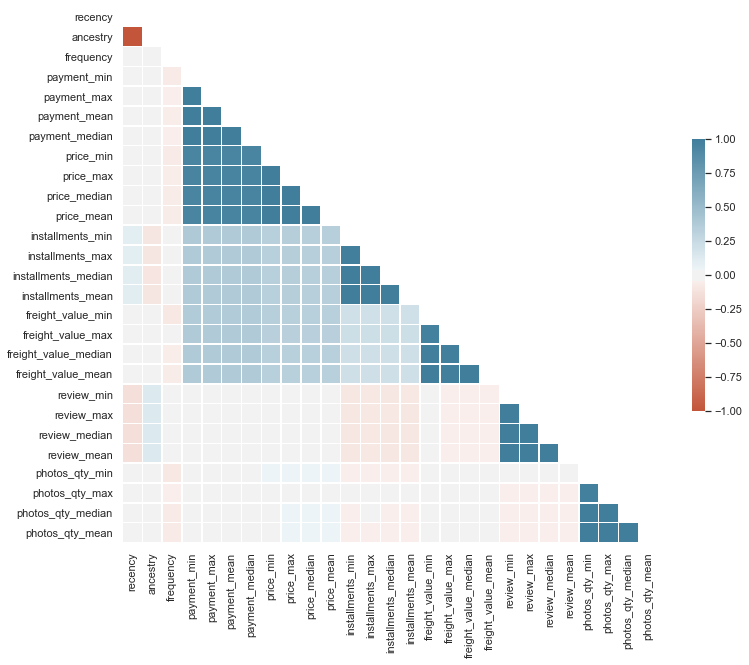

In [258]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_5_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [259]:
# Suppression des features trop corrélées
df_5_months = df_5_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_5_months.shape

(1218, 8)

<AxesSubplot:>

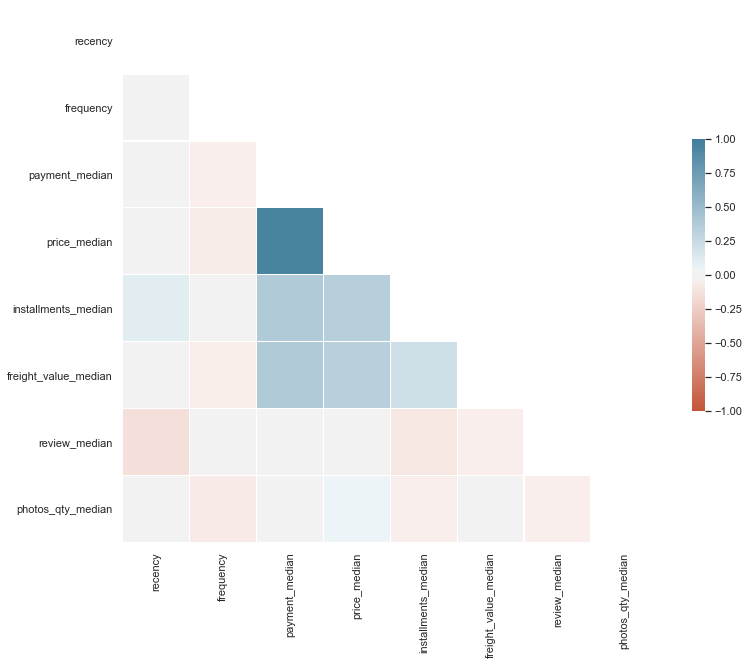

In [260]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_5_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 6 mois

## Features basées sur la récence

In [261]:
# 6 mois
df_6_months = df_feat_sel.loc[df_feat_sel['order_purchase_timestamp'] < '2017-03-04', :]
df_6_months.shape

(3653, 18)

In [262]:
df_6_months['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [263]:
df_6_months['order_purchase_timestamp'].max()

Timestamp('2017-03-03 23:50:26')

In [264]:
# recency 

most_recent_purchase_date_6_months = df_6_months['order_purchase_timestamp'].max()
most_recent_purchase_date_6_months

Timestamp('2017-03-03 23:50:26')

In [265]:
df_recency_6_months = df_6_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(recency, most_recent_purchase_date)
df_recency_6_months.name = 'recency'
df_recency_6_months = pd.DataFrame(df_recency_6_months)
df_recency_6_months

,recency
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,589
002b4cd83fabaffaa475f78ea5ef3e08,578
0032c76b20340da25249092a268ce66c,696
0055b522bc89cbfbf376d8b59a628470,548
0087eede471173af78d789df249c3a45,563
...,...
ffa46fd1f769dfbdd6c039550b420949,562
ffb973f2bb1c0cb807a99341a9b20dcd,693
ffba9f9dff87b05e310ecc46c8591044,552


In [266]:
# ancestry
most_old_purchase_date_6_months = df_6_months['order_purchase_timestamp'].min()
most_old_purchase_date_6_months

Timestamp('2016-09-04 21:15:19')

In [267]:
df_ancestry_6_months = df_6_months[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').apply(ancestry, most_old_purchase_date)
df_ancestry_6_months.name = 'ancestry'
df_ancestry_6_months = pd.DataFrame(df_ancestry_6_months)
df_ancestry_6_months

,ancestry
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,139
002b4cd83fabaffaa475f78ea5ef3e08,149
0032c76b20340da25249092a268ce66c,31
0055b522bc89cbfbf376d8b59a628470,179
0087eede471173af78d789df249c3a45,164
...,...
ffa46fd1f769dfbdd6c039550b420949,165
ffb973f2bb1c0cb807a99341a9b20dcd,35
ffba9f9dff87b05e310ecc46c8591044,175


# Features de fréquence

In [268]:
# Nombre de commande passée par chaque client unique

df_frequency_6_months = df_6_months[['customer_unique_id', 'order_id']].drop_duplicates().value_counts('customer_unique_id')
df_frequency_6_months.name = 'frequency'
df_frequency_6_months = pd.DataFrame(df_frequency_6_months)
df_frequency_6_months

,frequency
customer_unique_id,
12f5d6e1cbf93dafd9dcc19095df0b3d,6
a239b8e2fbce33780f1f1912e2ee5275,4
83e7958a94bd7f74a9414d8782f87628,4
c76762dfb642ac154475239639f7f8f4,3
6222ef69df52b4ed71be551725551cc0,3
...,...
554692dcba8b169a3e0ec2ef1c8bd473,1
555f8bf70ca6d707e83c484e3ff359c3,1
55845d91497951227fd70e450ffb35e0,1


# Features monétaires

In [269]:
# Cout minimale, maximale, moyen et median de chaque commande par client unique

df_monetary_value_6_months = df_6_months[['customer_unique_id','payment_value']].groupby('customer_unique_id').agg(['min', 'max', 'mean', 'median'])
df_monetary_value_6_months.columns = df_monetary_value_6_months.columns.get_level_values(1)
df_monetary_value_6_months.columns = ['payment_' + col for col in df_monetary_value_6_months.columns]
df_monetary_value_6_months

,payment_min,payment_max,payment_mean,payment_median
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,76.11,76.11,76.11,76.11
002b4cd83fabaffaa475f78ea5ef3e08,64.42,64.42,64.42,64.42
0032c76b20340da25249092a268ce66c,144.94,144.94,144.94,144.94
0055b522bc89cbfbf376d8b59a628470,364.75,364.75,364.75,364.75
0087eede471173af78d789df249c3a45,151.11,151.11,151.11,151.11
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,95.67,95.67,95.67,95.67
ffb973f2bb1c0cb807a99341a9b20dcd,109.02,109.02,109.02,109.02
ffba9f9dff87b05e310ecc46c8591044,1626.83,1626.83,1626.83,1626.83


In [270]:
# Cout minimale/maximale/moyenne et mediane des produits individuels achetés par chaque client unique

df_price_6_months = df_6_months.groupby(['customer_unique_id']).agg({ 'price' : ['min', 'max', 'median','mean']})
df_price_6_months.columns = df_price_6_months.columns.get_level_values(1)
df_price_6_months.columns = ['price_' + col for col in df_price_6_months.columns]
df_price_6_months

,price_min,price_max,price_median,price_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,59.99,59.99,59.99,59.99
002b4cd83fabaffaa475f78ea5ef3e08,49.90,49.90,49.90,49.90
0032c76b20340da25249092a268ce66c,128.90,128.90,128.90,128.90
0055b522bc89cbfbf376d8b59a628470,328.00,328.00,328.00,328.00
0087eede471173af78d789df249c3a45,126.99,126.99,126.99,126.99
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,79.90,79.90,79.90,79.90
ffb973f2bb1c0cb807a99341a9b20dcd,39.90,47.40,43.65,43.65
ffba9f9dff87b05e310ecc46c8591044,1591.20,1591.20,1591.20,1591.20


In [271]:
# Nombre de mensualité minimale/maximale/moyenne et mediane par client unique

df_installments_6_months = df_6_months.groupby(['customer_unique_id']).agg({ 'payment_installments' : ['min', 'max', 'median','mean']})
df_installments_6_months.columns = df_installments_6_months.columns.get_level_values(1)
df_installments_6_months.columns = ['installments_' + col for col in df_installments_6_months.columns]
df_installments_6_months

,installments_min,installments_max,installments_median,installments_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,1,1,1.0,1.0
002b4cd83fabaffaa475f78ea5ef3e08,1,1,1.0,1.0
0032c76b20340da25249092a268ce66c,1,1,1.0,1.0
0055b522bc89cbfbf376d8b59a628470,1,1,1.0,1.0
0087eede471173af78d789df249c3a45,1,1,1.0,1.0
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,1,1,1.0,1.0
ffb973f2bb1c0cb807a99341a9b20dcd,6,6,6.0,6.0
ffba9f9dff87b05e310ecc46c8591044,5,5,5.0,5.0


In [272]:
# Frais de transports minimale/maximale/moyenne et mediane payés par commande par chaque client unique

df_freight_value_6_months = df_6_months.groupby(['customer_unique_id']).agg({ 'freight_value' : ['min', 'max', 'median','mean']})
df_freight_value_6_months.columns = df_freight_value_6_months.columns.get_level_values(1)
df_freight_value_6_months.columns = ['freight_value_' + col for col in df_freight_value_6_months.columns]
df_freight_value_6_months

,freight_value_min,freight_value_max,freight_value_median,freight_value_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,16.12,16.12,16.12,16.12
002b4cd83fabaffaa475f78ea5ef3e08,14.52,14.52,14.52,14.52
0032c76b20340da25249092a268ce66c,16.04,16.04,16.04,16.04
0055b522bc89cbfbf376d8b59a628470,36.75,36.75,36.75,36.75
0087eede471173af78d789df249c3a45,24.12,24.12,24.12,24.12
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,15.77,15.77,15.77,15.77
ffb973f2bb1c0cb807a99341a9b20dcd,9.31,12.41,10.86,10.86
ffba9f9dff87b05e310ecc46c8591044,35.63,35.63,35.63,35.63


# Autres features axé sur les clients

In [273]:
# Notes données aux vendeurs minimale/maximale/moyenne et mediane par client unique

df_review_6_months = df_6_months.groupby(['customer_unique_id']).agg({ 'review_score' : ['min', 'max', 'median','mean']})
df_review_6_months.columns = df_review_6_months.columns.get_level_values(1)
df_review_6_months.columns = ['review_' + col for col in df_review_6_months.columns]
df_review_6_months

,review_min,review_max,review_median,review_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,4,4,4.0,4.0
002b4cd83fabaffaa475f78ea5ef3e08,2,2,2.0,2.0
0032c76b20340da25249092a268ce66c,4,4,4.0,4.0
0055b522bc89cbfbf376d8b59a628470,5,5,5.0,5.0
0087eede471173af78d789df249c3a45,5,5,5.0,5.0
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,5,5,5.0,5.0
ffb973f2bb1c0cb807a99341a9b20dcd,5,5,5.0,5.0
ffba9f9dff87b05e310ecc46c8591044,5,5,5.0,5.0


In [274]:
# Nombre de photos minimale/maximale/moyenne et mediane des produits achetés par chaque client unique

df_photos_6_months = df_6_months.groupby(['customer_unique_id']).agg({ 'product_photos_qty' : ['min', 'max', 'median','mean']})
df_photos_6_months.columns = df_photos_6_months.columns.get_level_values(1)
df_photos_6_months.columns = ['photos_qty_' + col for col in df_photos_6_months.columns]
df_photos_6_months

,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,
00115fc7123b5310cf6d3a3aa932699e,6.0,6.0,6.0,6.0
002b4cd83fabaffaa475f78ea5ef3e08,5.0,5.0,5.0,5.0
0032c76b20340da25249092a268ce66c,1.0,1.0,1.0,1.0
0055b522bc89cbfbf376d8b59a628470,5.0,5.0,5.0,5.0
0087eede471173af78d789df249c3a45,3.0,3.0,3.0,3.0
...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,3.0,3.0,3.0,3.0
ffb973f2bb1c0cb807a99341a9b20dcd,3.0,3.0,3.0,3.0
ffba9f9dff87b05e310ecc46c8591044,3.0,3.0,3.0,3.0


In [275]:
# Nombre de régions  différentes par client

df_cust_state_6_months = df_6_months[['customer_unique_id', 'customer_state']].groupby(['customer_unique_id']).count()
df_cust_state_6_months

,customer_state
customer_unique_id,
00115fc7123b5310cf6d3a3aa932699e,1
002b4cd83fabaffaa475f78ea5ef3e08,1
0032c76b20340da25249092a268ce66c,1
0055b522bc89cbfbf376d8b59a628470,1
0087eede471173af78d789df249c3a45,1
...,...
ffa46fd1f769dfbdd6c039550b420949,1
ffb973f2bb1c0cb807a99341a9b20dcd,2
ffba9f9dff87b05e310ecc46c8591044,1


In [276]:
# Affiche les clients ayant vécu dans différentes régions

df_custom_multi_state_6_months = df_cust_state_6_months.loc[df_cust_state_6_months['customer_state']>1]
df_custom_multi_state_6_months

,customer_state
customer_unique_id,
012b8001e47392df808a454083a74b74,2
028df9d72fe22595a5da837157f1258b,2
0379a6f96d9befaf749609ba52b17783,5
040e4df45a02c9d398c233227f207f67,2
06435ea24fa29c3b3727990f2f67d7ec,2
...,...
fe947af6540d580b9703d0332d04f0e3,2
ff39ae410be7f9b3a2457c546c6f67de,2
ff68ad2883e793597f1c343dd6505f5d,2


In [277]:
# Sélectionner la première région pour chaquee client dans le dataframe pour du One Hot Encoding

df_custom_single_state_6_months = df_6_months[['customer_unique_id', 'customer_state']].drop_duplicates(subset=['customer_unique_id'], keep='first')
df_custom_single_state_6_months 

,customer_unique_id,customer_state
19,9e8993ba2665307b71bd1641c2e1cb3d,MG
56,236655441ae8dd4485fd328d918186fa,BA
72,ae6c2808c02ba82b0d0977e1ab5d68bc,MG
107,8fb0376e151713747c496f5786f8e042,SP
179,8331d73eb4989100a9a2dfa095dceaa7,BA
...,...,...
115425,95e70fa5b9014a6a718b63350260356c,RJ
115456,161fd742f7217e46d7924d781e8705af,MG
115560,c9db46713c0120a12c6abbed0f949993,SP
115572,9ccff5067614ac5510320fed6e4dda46,SP


# AGREGATION DES FEATURES

In [278]:
# Affiche les dimensions pour voir si le df va perdre les lignes non contenu dans les df axés clients

df_6_months.shape 

(3653, 18)

In [279]:
df_6_months = pd.merge(df_recency_6_months,df_ancestry_6_months,  on='customer_unique_id')
df_6_months.shape

(2899, 2)

In [280]:
df_6_months = pd.merge(df_6_months, df_frequency_6_months,  on='customer_unique_id')

In [281]:
df_6_months = pd.merge(df_6_months, df_monetary_value_6_months, on='customer_unique_id')

In [282]:
df_6_months = pd.merge(df_6_months, df_price_6_months,  on='customer_unique_id')

In [283]:
df_6_months = pd.merge(df_6_months, df_installments_6_months,  on='customer_unique_id')

In [284]:
df_6_months = pd.merge(df_6_months, df_freight_value_6_months,  on='customer_unique_id')

In [285]:
df_6_months = pd.merge(df_6_months, df_review_6_months,  on='customer_unique_id')

In [286]:
df_6_months = pd.merge(df_6_months, df_photos_6_months,  on='customer_unique_id')
df_6_months.shape

(2899, 27)

In [287]:
df_6_months

,recency,ancestry,frequency,payment_min,payment_max,payment_mean,payment_median,price_min,price_max,price_median,price_mean,installments_min,installments_max,installments_median,installments_mean,freight_value_min,freight_value_max,freight_value_median,freight_value_mean,review_min,review_max,review_median,review_mean,photos_qty_min,photos_qty_max,photos_qty_median,photos_qty_mean
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
00115fc7123b5310cf6d3a3aa932699e,589,139,1,76.11,76.11,76.11,76.11,59.99,59.99,59.99,59.99,1,1,1.0,1.0,16.12,16.12,16.12,16.12,4,4,4.0,4.0,6.0,6.0,6.0,6.0
002b4cd83fabaffaa475f78ea5ef3e08,578,149,1,64.42,64.42,64.42,64.42,49.90,49.90,49.90,49.90,1,1,1.0,1.0,14.52,14.52,14.52,14.52,2,2,2.0,2.0,5.0,5.0,5.0,5.0
0032c76b20340da25249092a268ce66c,696,31,1,144.94,144.94,144.94,144.94,128.90,128.90,128.90,128.90,1,1,1.0,1.0,16.04,16.04,16.04,16.04,4,4,4.0,4.0,1.0,1.0,1.0,1.0
0055b522bc89cbfbf376d8b59a628470,548,179,1,364.75,364.75,364.75,364.75,328.00,328.00,328.00,328.00,1,1,1.0,1.0,36.75,36.75,36.75,36.75,5,5,5.0,5.0,5.0,5.0,5.0,5.0
0087eede471173af78d789df249c3a45,563,164,1,151.11,151.11,151.11,151.11,126.99,126.99,126.99,126.99,1,1,1.0,1.0,24.12,24.12,24.12,24.12,5,5,5.0,5.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffa46fd1f769dfbdd6c039550b420949,562,165,1,95.67,95.67,95.67,95.67,79.90,79.90,79.90,79.90,1,1,1.0,1.0,15.77,15.77,15.77,15.77,5,5,5.0,5.0,3.0,3.0,3.0,3.0
ffb973f2bb1c0cb807a99341a9b20dcd,693,35,1,109.02,109.02,109.02,109.02,39.90,47.40,43.65,43.65,6,6,6.0,6.0,9.31,12.41,10.86,10.86,5,5,5.0,5.0,3.0,3.0,3.0,3.0
ffba9f9dff87b05e310ecc46c8591044,552,175,1,1626.83,1626.83,1626.83,1626.83,1591.20,1591.20,1591.20,1591.20,5,5,5.0,5.0,35.63,35.63,35.63,35.63,5,5,5.0,5.0,3.0,3.0,3.0,3.0


<AxesSubplot:>

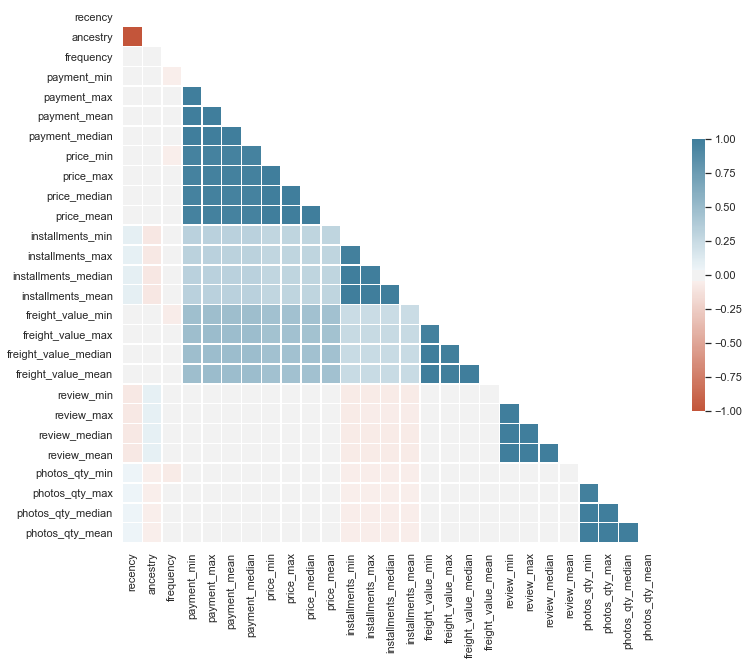

In [288]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_6_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [289]:
# Suppression des features trop corrélées

df_6_months = df_6_months.drop(['ancestry','payment_min', 'payment_max' ,'payment_mean', 'price_min', 'price_max',
                                  'price_mean', 'installments_min', 'installments_max', 'installments_mean', 
                                  'freight_value_min', 'freight_value_max', 'freight_value_mean', 'review_min', 'review_max',
                                  'review_mean', 'photos_qty_min', 'photos_qty_max', 'photos_qty_mean']
                                 , axis=1)
df_6_months.shape

(2899, 8)

<AxesSubplot:>

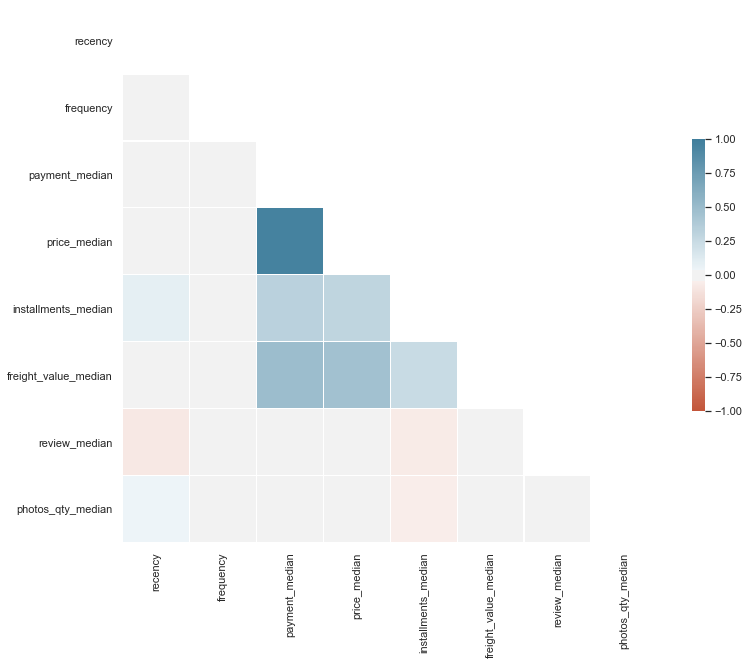

In [290]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_6_months.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(12, 10))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [291]:
df_6_months.shape

(2899, 8)

In [292]:
df_1_months.shape

(11, 8)

In [293]:
df_2_months.shape

(300, 8)

In [294]:
df_3_months.shape

(300, 8)

In [295]:
df_4_months.shape

(301, 8)

In [296]:
df_5_months.shape

(1218, 8)

In [297]:
df_6_months.shape

(2899, 8)

# 5.  ENREGISTREMENT DES DATAFRAMES

In [ ]:
df_1_months.to_csv('df1.csv', index= None)

In [ ]:
df_2_months.to_csv('df2.csv', index= None)

In [ ]:
df_3_months.to_csv('df3.csv', index= None)

In [ ]:
df_4_months.to_csv('df4.csv', index= None)

In [ ]:
df_5_months.to_csv('df5.csv', index= None)

In [ ]:
df_6_months.to_csv('df6.csv', index= None)

In [ ]:
# enregistrement du dataframe
df_24_months.to_csv('df24.csv', index= None)